In [1]:
from horemheb.config import AnalysisConfig
from horemheb.loader import load_temperature_data
from horemheb.segments import process_segments

import numpy as np
import pandas as pd
from dataclasses import asdict
from typing import Dict, List

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Configure analysis parameters
config = AnalysisConfig(
    delay_time=0, #80, #300, #240, #80, #240, #180, #120,
    before_sunrise_delta_minutes=0,
    resample_minutes=5
)

In [3]:
temperature_data_file_old_door = 'temperature_logB_12.csv'
temperature_data_file = 'temperature_logC_2025-03-12.csv'

# Filter New Door data after the specified timestamp
cutoff_time = '2025-02-27 19:48:04'

---
### Old Door

In [4]:
# Old Door
dfo, dfo_r1, dfo_r2 = load_temperature_data(
    temperature_data_file,
    config,
    cutoff_time=cutoff_time,
    comparison='<='
)

segments_old = process_segments(dfo_r1, dfo_r2, config)

---
### New Door

In [5]:
# New Door
dfn, dfn_r1, dfn_r2 = load_temperature_data(
    temperature_data_file,
    config,
    cutoff_time=cutoff_time,
    comparison='>='
)

# Find and process segments
segments_new = process_segments(dfn_r1, dfn_r2, config)

In [6]:
segments_new[0]['delay_time'], segments_new[0]['start_time']

(datetime.datetime(2025, 2, 27, 22, 55), Timestamp('2025-02-27 22:55:00'))

In [7]:
# Convert timestamps to minutes from start
def get_time_temps(seg):
    delay_time = pd.Timestamp(seg['delay_time'])
    sunrise = pd.Timestamp(seg['sunrise_time'])
    mask1 = (seg['temp1'].index >= delay_time) & (seg['temp1'].index <= sunrise)

    def _one_and_two(temp_name: str):
        time_series = seg[temp_name][mask1]
        start_time = time_series.index[0]
        time_hours = [(t - start_time).total_seconds() / 60 /60 for t in time_series.index]
        temperatures = time_series.values
        return np.array(time_hours), np.array(temperatures)
    
    time_hours1, temp1 = _one_and_two("temp1")
    time_hours2, temp2 = _one_and_two("temp2")

    return time_hours1, temp1, time_hours2, temp2

In [8]:
ii = 9
tm1, t1, tm2, t2 = get_time_temps(segments_new[ii])

In [9]:
from scipy.interpolate import UnivariateSpline

# s parameter controls smoothing (s=0 forces exact interpolation, larger s = more smoothing)
spl = UnivariateSpline(tm1, t1, s=len(tm1)*0.001)  # adjust the 0.001 factor to control smoothing
t1_smooth = spl(tm1)

spl = UnivariateSpline(tm2, t2, s=len(tm2)*0.01)  # adjust the 0.001 factor to control smoothing
t2_smooth = spl(tm2)

In [10]:
np.array_equal(tm1, tm2)

True

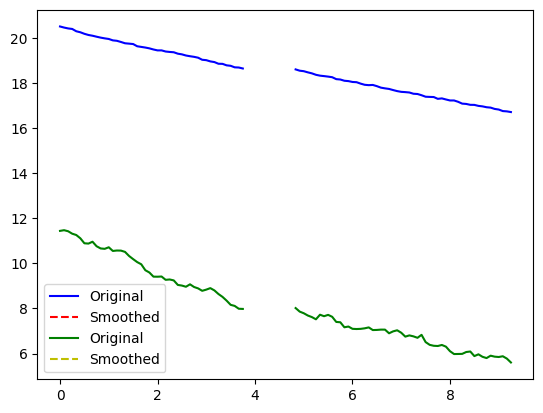

In [11]:
plt.plot(tm1, t1, 'b-', label='Original')
plt.plot(tm1, t1_smooth, 'r--', label='Smoothed')
plt.plot(tm2, t2, 'g-', label='Original')
plt.plot(tm2, t2_smooth, 'y--', label='Smoothed')
plt.legend()
plt.show()

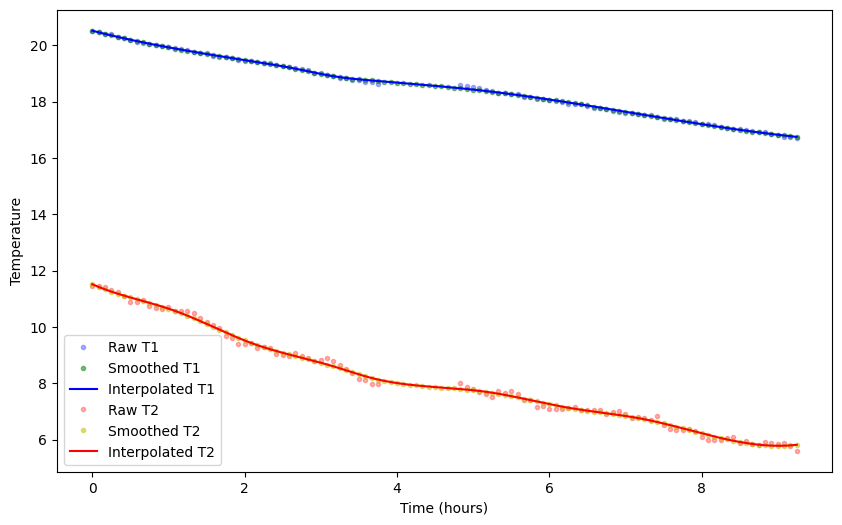

In [12]:
from scipy.interpolate import UnivariateSpline

mask1 = ~np.isnan(t1)
# s parameter controls smoothing (s=0 forces exact interpolation, larger s = more smoothing)
t1_interp = UnivariateSpline(tm1[mask1], t1[mask1], s=len(tm1)*0.001)  # adjust the 0.001 factor to control smoothing
t1_smooth = t1_interp(tm1)

mask2 = ~np.isnan(t2)
t2_interp = UnivariateSpline(tm2[mask2], t2[mask2], s=len(tm2)*0.01)  # adjust the 0.001 factor to control smoothing
t2_smooth = t2_interp(tm2)

# Verify the interpolation by plotting
t_fine = np.linspace(min(tm1), max(tm1), 1000)
plt.figure(figsize=(10,6))
plt.plot(tm1, t1, 'b.', alpha=0.3, label='Raw T1')
plt.plot(tm1, t1_smooth, 'g.', alpha=0.5, label='Smoothed T1')
plt.plot(t_fine, t1_interp(t_fine), 'b-', label='Interpolated T1')
plt.plot(tm2, t2, 'r.', alpha=0.3, label='Raw T2')
plt.plot(tm2, t2_smooth, 'y.', alpha=0.5, label='Smoothed T2') 
plt.plot(t_fine, t2_interp(t_fine), 'r-', label='Interpolated T2')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature')
plt.legend()
plt.show()


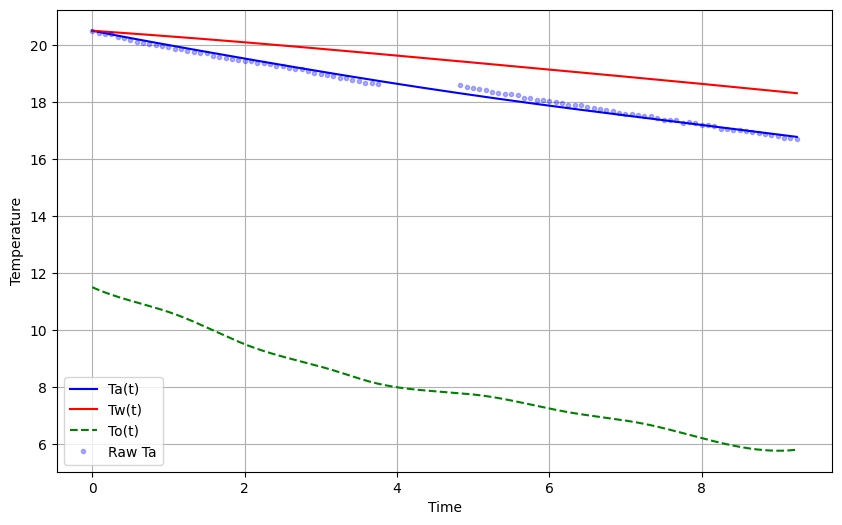

In [13]:
import numpy as np
from scipy.integrate import solve_ivp

def cooling_system(t, y, k1, k2, k3, k4, To_func):
    """
    System of ODEs:
    Ta' = k1*(Tw - Ta) + k2*(To - Ta)
    Tw' = k3*(To - Tw) + k4*(Ta - Tw)
    
    Args:
        t: time point
        y: array of [Ta, Tw]
        k1, k2, k3, k4: coupling constants
        To_func: function that returns To at any time t
    """
    Ta, Tw = y
    To = To_func(t)
    
    dTa_dt = k1*(Tw - Ta) + k2*(To - Ta)
    dTw_dt = k3*(To - Tw) + k4*(Ta - Tw)
    
    return [dTa_dt, dTw_dt]

# Define parameters
#k1, k2, k3, k4 = 0.1, 0.2, 0.15, 0.25  # example values
Ta0, Tw0 = t1_interp(0), t1_interp(0)  # initial conditions
t_span = (tm1[0], tm1[-1]) #(0, 8)  # time domain
t_eval = np.linspace(0, tm1[-1], 1000)  # points at which to evaluate solution

# Define To(t) - for example, a simple function
#def To_func(t):
#    return 15.0 + 5.0 * np.sin(t/2)  # example: oscillating outside temperature
To_func = t2_interp

k1, k2, k3, k4 = 10.*0.5/24., 1.4/24., 0.5/24., 0.  # example values

# Solve the system
solution = solve_ivp(
    cooling_system, 
    t_span, 
    [Ta0, Tw0], 
    args=(k1, k2, k3, k4, To_func),
    t_eval=t_eval,
    method='RK45'  # Runge-Kutta 4(5) method
)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(solution.t, solution.y[0], 'b-', label='Ta(t)')
plt.plot(solution.t, solution.y[1], 'r-', label='Tw(t)')
plt.plot(solution.t, To_func(solution.t), 'g--', label='To(t)')
plt.plot(tm1, t1, 'b.', alpha=0.3, label='Raw Ta')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

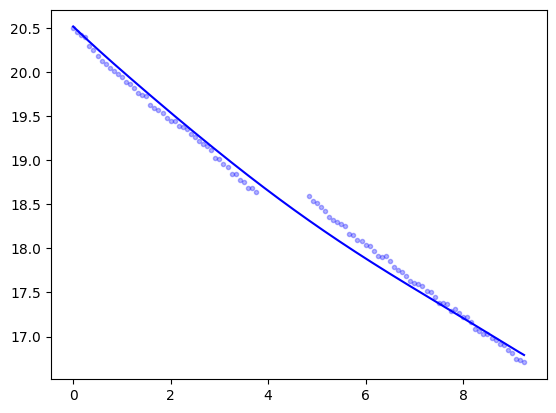

In [14]:
plt.plot(solution.t, solution.y[0], 'b-', label='Ta(t)')
plt.plot(tm1, t1, 'b.', alpha=0.3, label='Raw Ta')

Optimized parameters:
k1 = 0.208333
k2 = 0.058333
k3 = 0.020833


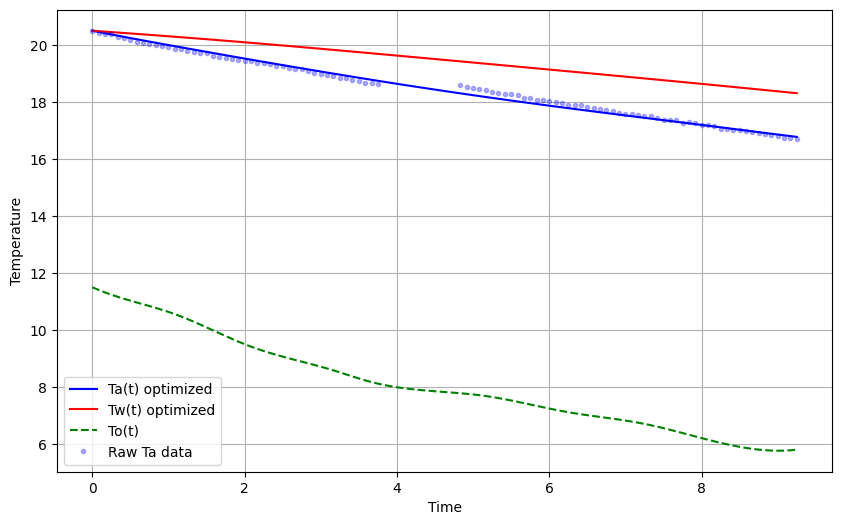

In [15]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# Define the ODE system (keep your existing cooling_system function)
# ... existing cooling_system function ...

# Define an objective function that measures the difference between solution and data
def objective(params, t_data, T_data, Ta0, Tw0, To_func):
    k1, k2, k3 = params
    k4 = 0.0  # fixed
    
    # Solve the ODE system with these parameters
    solution = solve_ivp(
        cooling_system,
        (t_data[0], t_data[-1]),
        [Ta0, Tw0],
        args=(k1, k2, k3, k4, To_func),
        t_eval=t_data,
        method='RK45'
    )
    
    # Calculate error between solution and data
    error = np.mean((solution.y[0] - T_data)**2)  # Mean squared error
    return error

# Initial guess for parameters
initial_guess = [10.*0.5/24., 1.4/24., 0.5/24.]  # your current values

# Run optimization
result = minimize(
    objective,
    initial_guess,
    args=(tm1, t1, Ta0, Tw0, To_func),
    method='Nelder-Mead',  # You can try other methods like 'L-BFGS-B'
    options={'maxiter': 1000}
)

# Get optimized parameters
k1_opt, k2_opt, k3_opt = result.x
print(f"Optimized parameters:")
print(f"k1 = {k1_opt:.6f}")
print(f"k2 = {k2_opt:.6f}")
print(f"k3 = {k3_opt:.6f}")

# Solve and plot with optimized parameters
solution_opt = solve_ivp(
    cooling_system,
    (tm1[0], tm1[-1]),
    [Ta0, Tw0],
    args=(k1_opt, k2_opt, k3_opt, 0.0, To_func),
    t_eval=tm1,
    method='RK45'
)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(solution_opt.t, solution_opt.y[0], 'b-', label='Ta(t) optimized')
plt.plot(solution_opt.t, solution_opt.y[1], 'r-', label='Tw(t) optimized')
plt.plot(tm1, To_func(tm1), 'g--', label='To(t)')
plt.plot(tm1, t1, 'b.', alpha=0.3, label='Raw Ta data')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
1./0.061005, 1./0.037651

(16.39209900827801, 26.55971952936177)

Optimized parameters:
k1 = 0.208333
k2 = 0.058333
k3 = 0.020833


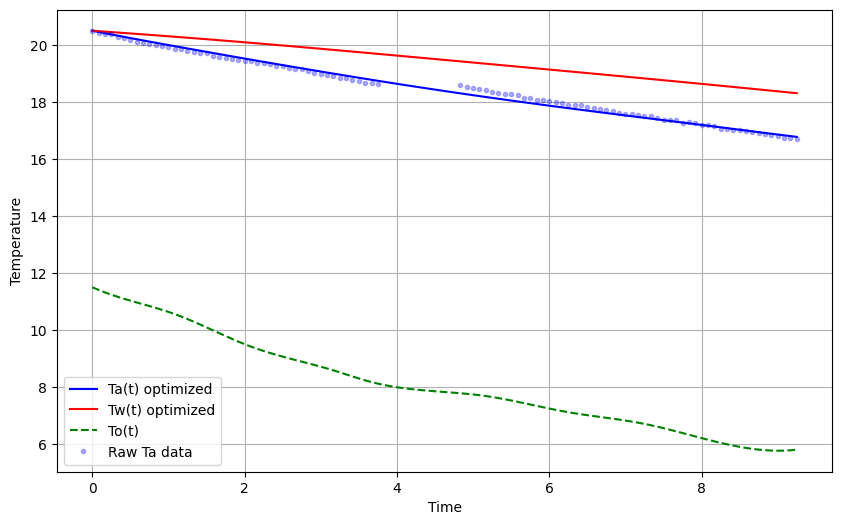

In [17]:
tm1, t1, tm2, t2 = get_time_temps(segments_new[9])

mask1 = ~np.isnan(t1)
t1_interp = UnivariateSpline(tm1[mask1], t1[mask1], s=len(tm1)*0.001)  # adjust the 0.001 factor to control smoothing
#t1_smooth = t1_interp(tm1)

mask2 = ~np.isnan(t2)
t2_interp = UnivariateSpline(tm2[mask2], t2[mask2], s=len(tm2)*0.01)  # adjust the 0.001 factor to control smoothing
#t2_smooth = t2_interp(tm2)

Ta0, Tw0 = t1_interp(0), t1_interp(0)  # initial conditions
t_span = (tm1[0], tm1[-1]) #(0, 8)  # time domain
t_eval = np.linspace(0, tm1[-1], 1000)  # points at which to evaluate solution

# Define To(t) - for example, a simple function
#def To_func(t):
#    return 15.0 + 5.0 * np.sin(t/2)  # example: oscillating outside temperature
To_func = t2_interp

# Run optimization
result = minimize(
    objective,
    initial_guess,
    args=(tm1, t1, Ta0, Tw0, To_func),
    method='Nelder-Mead',  # You can try other methods like 'L-BFGS-B'
    options={'maxiter': 1000}
)

# Get optimized parameters
k1_opt, k2_opt, k3_opt = result.x
print(f"Optimized parameters:")
print(f"k1 = {k1_opt:.6f}")
print(f"k2 = {k2_opt:.6f}")
print(f"k3 = {k3_opt:.6f}")

# Solve and plot with optimized parameters
solution_opt = solve_ivp(
    cooling_system,
    (tm1[0], tm1[-1]),
    [Ta0, Tw0],
    args=(k1_opt, k2_opt, k3_opt, 0.0, To_func),
    t_eval=tm1,
    method='RK45'
)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(solution_opt.t, solution_opt.y[0], 'b-', label='Ta(t) optimized')
plt.plot(solution_opt.t, solution_opt.y[1], 'r-', label='Tw(t) optimized')
plt.plot(tm1, To_func(tm1), 'g--', label='To(t)')
plt.plot(tm1, t1, 'b.', alpha=0.3, label='Raw Ta data')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

Optimized parameters:
k1 = 0.380048
k2 = 0.057629
k3 = 0.034138


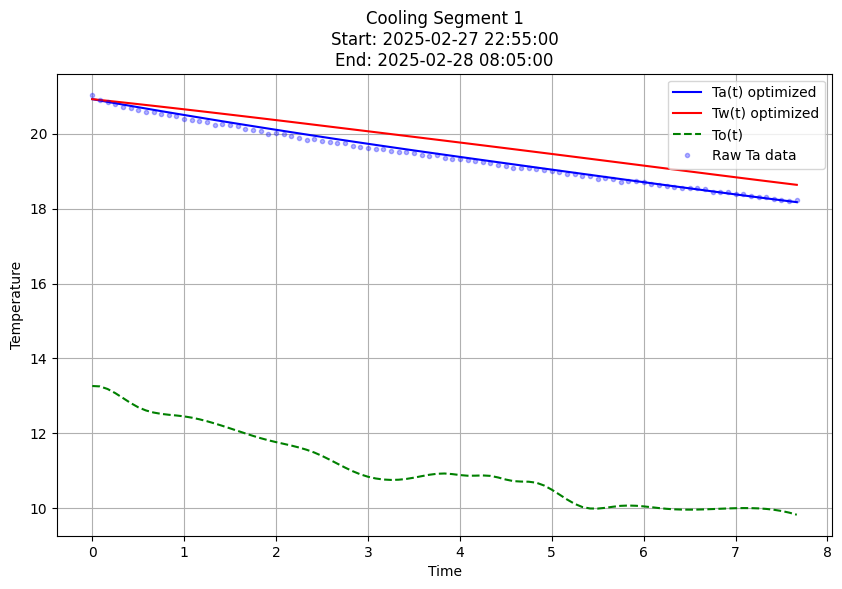

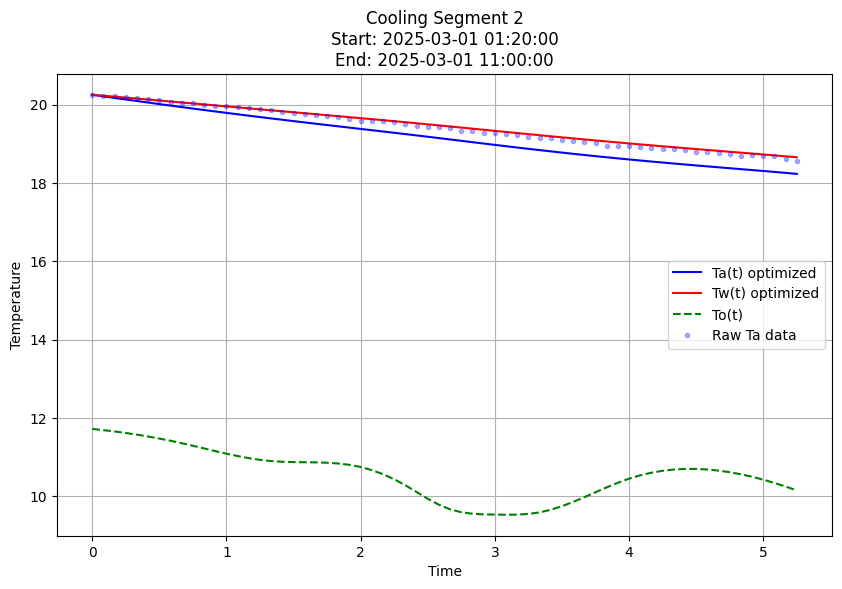

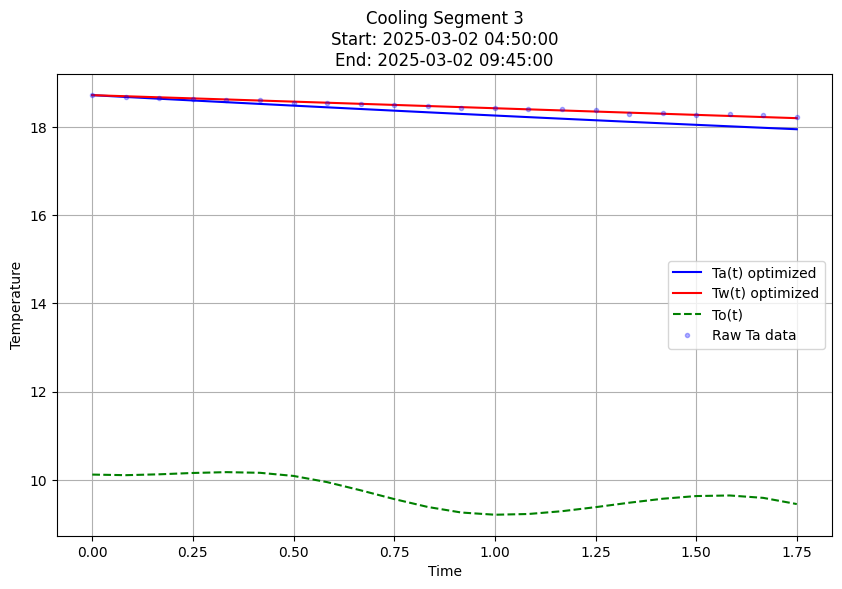

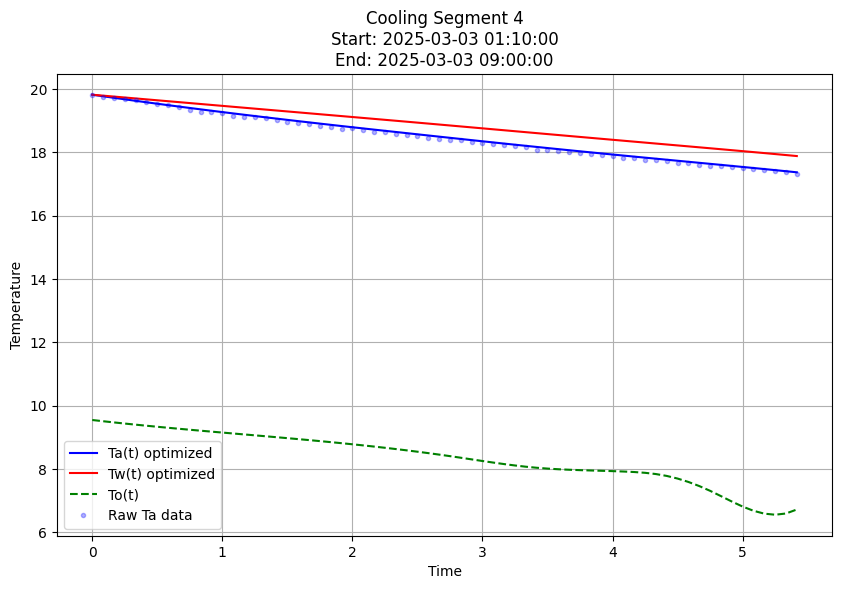

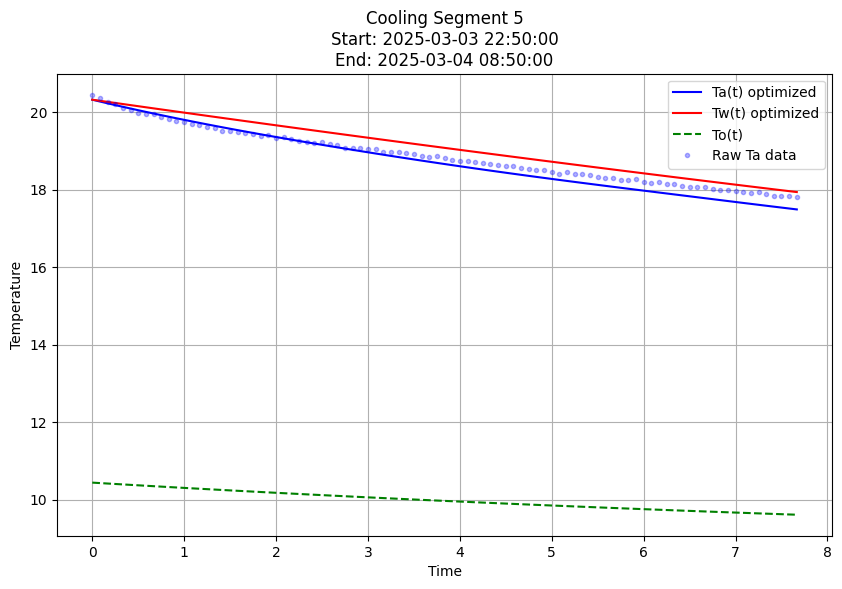

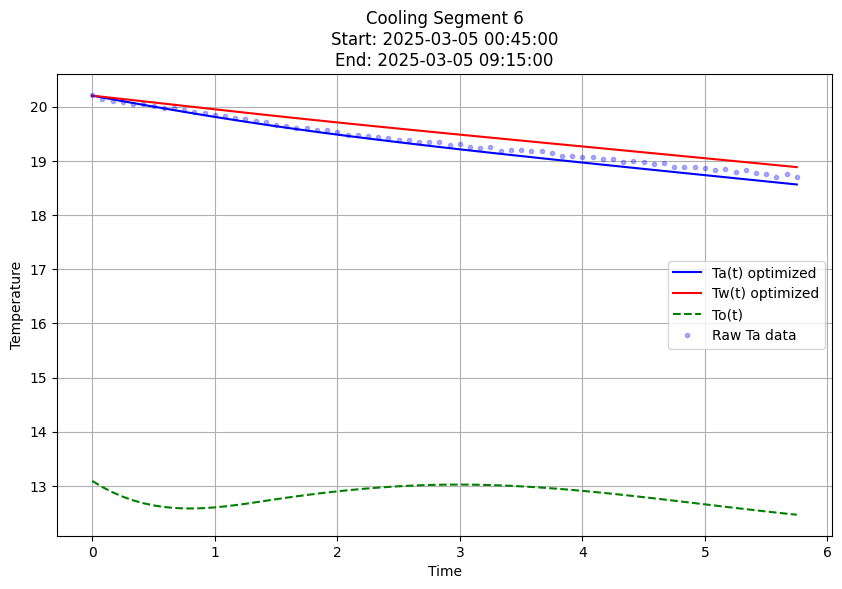

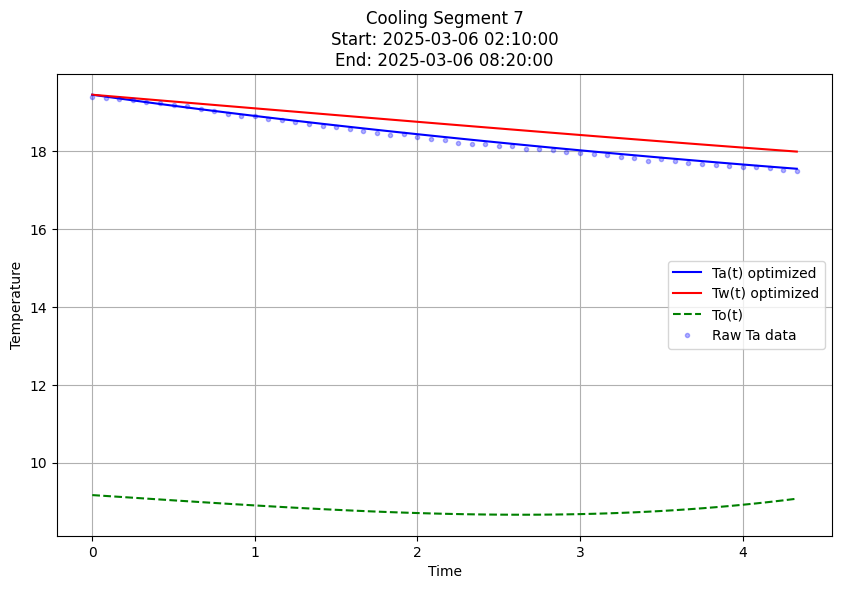

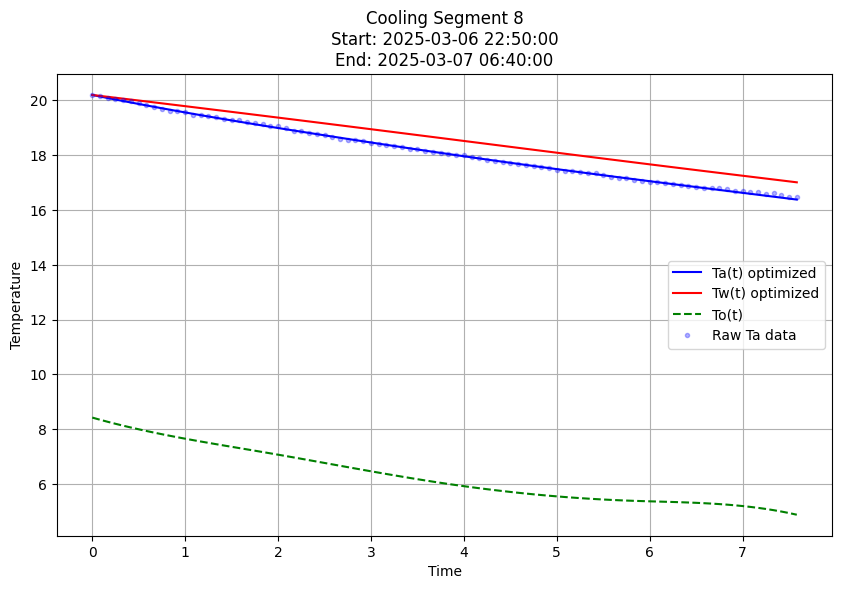

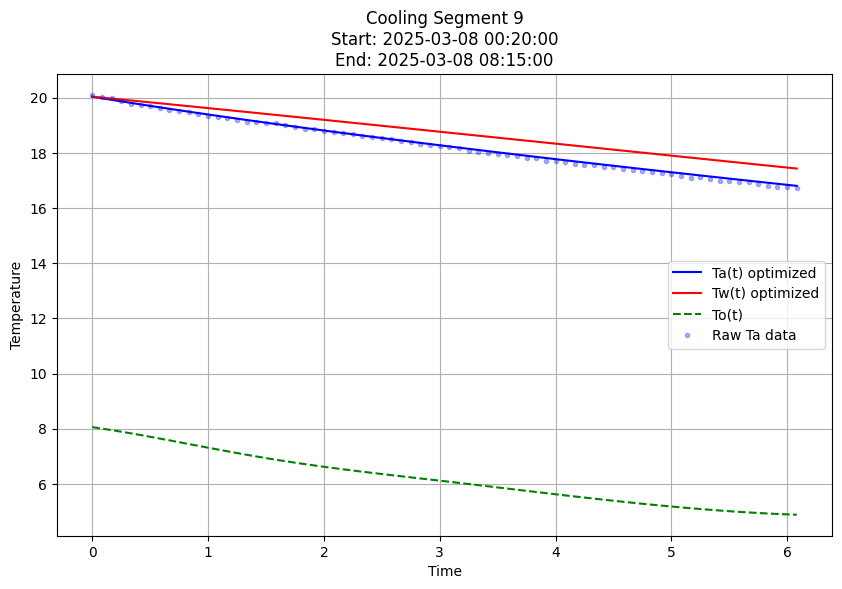

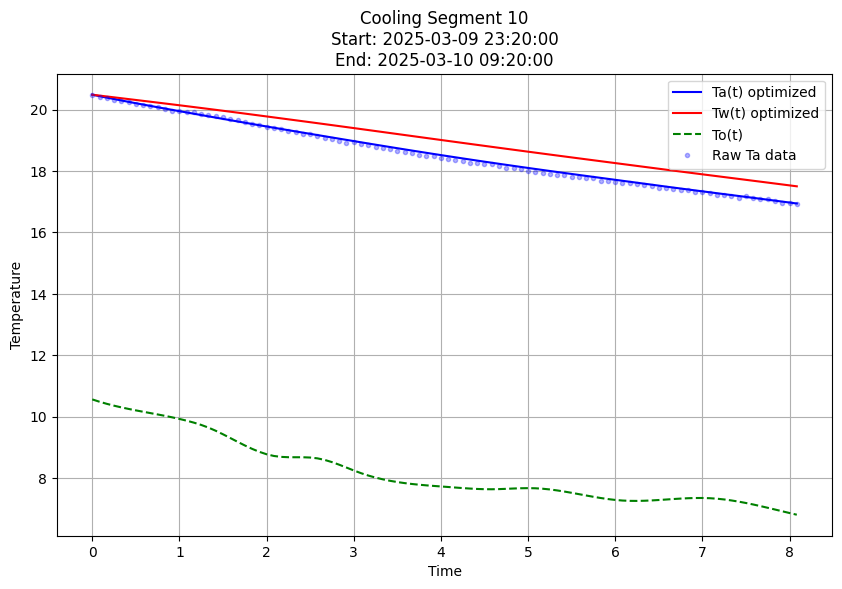

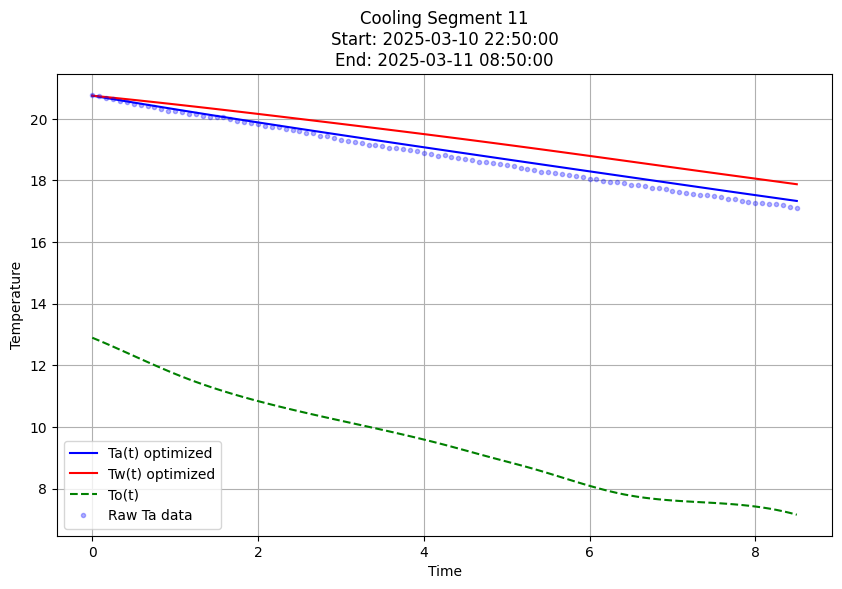

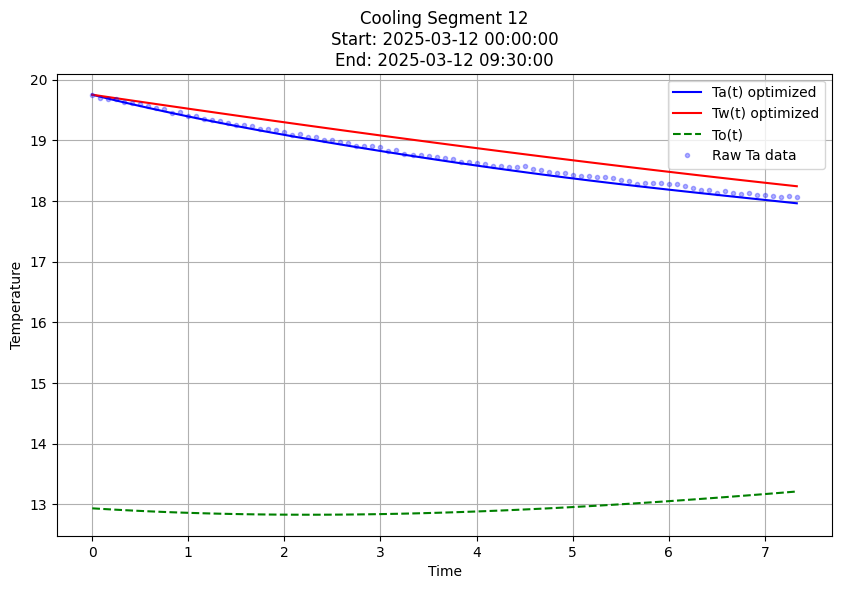

In [18]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline

def cooling_system(t, y, k1, k2, k3, k4, To_func):
    """
    System of ODEs:
    Ta' = k1*(Tw - Ta) + k2*(To - Ta)
    Tw' = k3*(To - Tw) + k4*(Ta - Tw)
    """
    Ta, Tw = y
    To = To_func(t)
    dTa_dt = k1*(Tw - Ta) + k2*(To - Ta)
    dTw_dt = k3*(To - Tw) + k4*(Ta - Tw)
    return [dTa_dt, dTw_dt]

def objective(params, segments):
    """
    Objective function that evaluates the fit across multiple segments
    """
    k1, k2, k3 = params
    k4 = 0.0  # fixed
    
    total_error = 0
    total_points = 0
    
    for segment in segments:
        # Get time and temperature data for this segment
        tm1, t1, tm2, t2 = get_time_temps(segment)
        
        # Create interpolation functions
        mask1 = ~np.isnan(t1)
        t1_interp = UnivariateSpline(tm1[mask1], t1[mask1], s=len(tm1)*0.001)
        
        mask2 = ~np.isnan(t2)
        t2_interp = UnivariateSpline(tm2[mask2], t2[mask2], s=len(tm2)*0.01)
        
        # Set initial conditions
        Ta0, Tw0 = t1_interp(0), t1_interp(0)
        
        # Solve ODE system for this segment
        solution = solve_ivp(
            cooling_system,
            (tm1[0], tm1[-1]),
            [Ta0, Tw0],
            args=(k1, k2, k3, k4, t2_interp),
            t_eval=tm1,
            method='RK45'
        )
        
        # Calculate error for this segment
        segment_error = np.mean((solution.y[0] - t1)**2)
        total_error += segment_error * len(tm1)
        total_points += len(tm1)
    
    # Return average error across all segments
    return total_error / total_points

# Select segments to use for optimization (e.g., first 10 segments)
segments_to_optimize = segments_new[:9] + segments_new[10:]  #[:10]

# Initial guess for parameters
initial_guess = [10.*0.5/24., 1.4/24., 0.5/24.]

# Run optimization
result = minimize(
    objective,
    initial_guess,
    args=(segments_to_optimize,),
    method='Nelder-Mead',
    options={'maxiter': 1000}
)

# Get optimized parameters
k1_opt, k2_opt, k3_opt = result.x
print(f"Optimized parameters:")
print(f"k1 = {k1_opt:.6f}")
print(f"k2 = {k2_opt:.6f}")
print(f"k3 = {k3_opt:.6f}")

# Plot results for each segment
for i, segment in enumerate(segments_to_optimize):
    tm1, t1, tm2, t2 = get_time_temps(segment)
    
    # Create interpolation functions
    mask1 = ~np.isnan(t1)
    t1_interp = UnivariateSpline(tm1[mask1], t1[mask1], s=len(tm1)*0.001)
    
    mask2 = ~np.isnan(t2)
    t2_interp = UnivariateSpline(tm2[mask2], t2[mask2], s=len(tm2)*0.01)
    
    # Set initial conditions
    Ta0, Tw0 = t1_interp(0), t1_interp(0)
    
    # Solve ODE system with optimized parameters
    solution_opt = solve_ivp(
        cooling_system,
        (tm1[0], tm1[-1]),
        [Ta0, Tw0],
        args=(k1_opt, k2_opt, k3_opt, 0.0, t2_interp),
        t_eval=tm1,
        method='RK45'
    )
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(solution_opt.t, solution_opt.y[0], 'b-', label='Ta(t) optimized')
    plt.plot(solution_opt.t, solution_opt.y[1], 'r-', label='Tw(t) optimized')
    plt.plot(tm1, t2_interp(tm1), 'g--', label='To(t)')
    plt.plot(tm1, t1, 'b.', alpha=0.3, label='Raw Ta data')
    plt.title(f'Cooling Segment {i+1}\n'
                f'Start: {segment["start_time"]}\n'
                f'End: {segment["end_time"]}')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid(True)
    plt.show()

In [19]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline
import time

# Select segments to use for optimization
if False: #True:    
    sup_title = "New Door"
    segments_to_optimize = segments_new[:9] + segments_new[10:]  #[:10]
else:
    sup_title = "Old Door"
    segments_to_optimize = segments_old


def cooling_system(t, y, k1, k2, k3, k4, To_func):
    """
    System of ODEs:
    Ta' = k1*(Tw - Ta) + k2*(To - Ta)
    Tw' = k3*(To - Tw) + k4*(Ta - Tw)
    """
    Ta, Tw = y
    To = To_func(t)
    dTa_dt = k1*(Tw - Ta) + k2*(To - Ta)
    dTw_dt = k3*(To - Tw) + k4*(Ta - Tw)
    return [dTa_dt, dTw_dt]

def objective(params, segments, precomputed_data=None):
    """
    Objective function that evaluates the fit across multiple segments
    """
    k1, k2, k3 = params
    k4 = 0.0  # fixed
    
    total_error = 0
    total_points = 0
    
    for i, segment in enumerate(segments):
        if precomputed_data is not None:
            tm1, t1, t1_interp, t2_interp, Ta0, Tw0 = precomputed_data[i]
        else:
            tm1, t1, tm2, t2 = get_time_temps(segment)
            mask1 = ~np.isnan(t1)
            t1_interp = UnivariateSpline(tm1[mask1], t1[mask1], s=len(tm1)*0.001)
            mask2 = ~np.isnan(t2)
            t2_interp = UnivariateSpline(tm2[mask2], t2[mask2], s=len(tm2)*0.01)
            Ta0, Tw0 = t1_interp(0), t1_interp(0)
        
        solution = solve_ivp(
            cooling_system,
            (tm1[0], tm1[-1]),
            [Ta0, Tw0],
            args=(k1, k2, k3, k4, t2_interp),
            t_eval=tm1,
            method='RK45'
        )
        
        segment_error = np.mean((solution.y[0] - t1)**2)
        total_error += segment_error * len(tm1)
        total_points += len(tm1)
    
    return total_error / total_points

def optimize_cooling_system(segments_to_optimize, sup_title):
    # Precompute data for all segments
    print("Precomputing data for segments...")
    precomputed_data = []
    for segment in segments_to_optimize:
        tm1, t1, tm2, t2 = get_time_temps(segment)
        mask1 = ~np.isnan(t1)
        t1_interp = UnivariateSpline(tm1[mask1], t1[mask1], s=len(tm1)*0.001)
        mask2 = ~np.isnan(t2)
        t2_interp = UnivariateSpline(tm2[mask2], t2[mask2], s=len(tm2)*0.01)
        Ta0, Tw0 = t1_interp(0), t1_interp(0)
        precomputed_data.append((tm1, t1, t1_interp, t2_interp, Ta0, Tw0))

    # Initial guess for parameters (scaled to be closer to 1)
    initial_guess = [10.*0.5/24., 1.4/24., 0.5/24.]

    # Define bounds for parameters (ensure they stay positive and within reasonable ranges)
    bounds = [
        (0, 1.0),  # k1: 0 to 1.0
        (0, 1.0),  # k2: 0 to 1.0
        (0, 1.0)   # k3: 0 to 1.0
    ]

    # Run multiple optimizations with different starting points
    print("Starting optimization with multiple initial points...")
    n_trials = 5
    best_result = None
    best_error = float('inf')

    for i in range(n_trials):
        # Generate random initial guess within bounds
        x0 = np.random.uniform(0, 1.0, 3)
        
        result = minimize(
            objective,
            x0,
            args=(segments_to_optimize, precomputed_data),
            method='L-BFGS-B',
            bounds=bounds,
            options={'maxiter': 1000}
        )
        
        if result.fun < best_error:
            best_error = result.fun
            best_result = result

    result = best_result

    # Get optimized parameters
    k1_opt, k2_opt, k3_opt = result.x

    # Calculate confidence intervals using the Hessian matrix
    print("Calculating confidence intervals...")
    hessian = result.hess_inv.todense()
    covariance = np.linalg.inv(hessian)
    std_errors = np.sqrt(np.diag(covariance))
    confidence_intervals = 1.96 * std_errors

    print("\n---" + sup_title + "---")
    print(f"\nOptimized parameters with 95% confidence intervals:")
    print(f"k1 = {k1_opt:.6f} ± {confidence_intervals[0]:.6f}")
    print(f"k2 = {k2_opt:.6f} ± {confidence_intervals[1]:.6f}")
    print(f"k3 = {k3_opt:.6f} ± {confidence_intervals[2]:.6f}")

    # Calculate R-squared value
    total_error = objective(result.x, segments_to_optimize, precomputed_data)
    total_variance = np.var(np.concatenate([seg['temp1'].values for seg in segments_to_optimize]))
    r_squared = 1 - (total_error / total_variance)

    print(f"\nGoodness of fit:")
    print(f"R-squared = {r_squared:.4f}")

    # Plot results for each segment
    print("\nGenerating plots...")
    for i, segment in enumerate(segments_to_optimize):
        tm1, t1, t1_interp, t2_interp, Ta0, Tw0 = precomputed_data[i]
        
        solution_opt = solve_ivp(
            cooling_system,
            (tm1[0], tm1[-1]),
            [Ta0, Tw0],
            args=(k1_opt, k2_opt, k3_opt, 0.0, t2_interp),
            t_eval=tm1,
            method='RK45'
        )
        
        plt.figure(figsize=(10, 6))
        plt.plot(solution_opt.t, solution_opt.y[0], 'b-', label='Ta(t) optimized')
        plt.plot(solution_opt.t, solution_opt.y[1], 'r-', label='Tw(t) optimized')
        plt.plot(tm1, t2_interp(tm1), 'g--', label='To(t)')
        plt.plot(tm1, t1, 'b.', alpha=0.3, label='Raw Ta data')
        plt.title(f'Cooling Segment {i+1}\n'
                    f'Start: {segment["start_time"]}\n'
                    f'End: {segment["end_time"]}')
        plt.xlabel('Time')
        plt.ylabel('Temperature')
        plt.legend()
        plt.grid(True)
        plt.show()

In [20]:
1./0.034, 1./0.038

(29.41176470588235, 26.315789473684212)

Precomputing data for segments...
Starting optimization with multiple initial points...
Calculating confidence intervals...

---New Door---

Optimized parameters with 95% confidence intervals:
k1 = 0.380045 ± 1.940062
k2 = 0.057627 ± 38.856012
k3 = 0.034139 ± 49.935999

Goodness of fit:
R-squared = 0.9849

Generating plots...


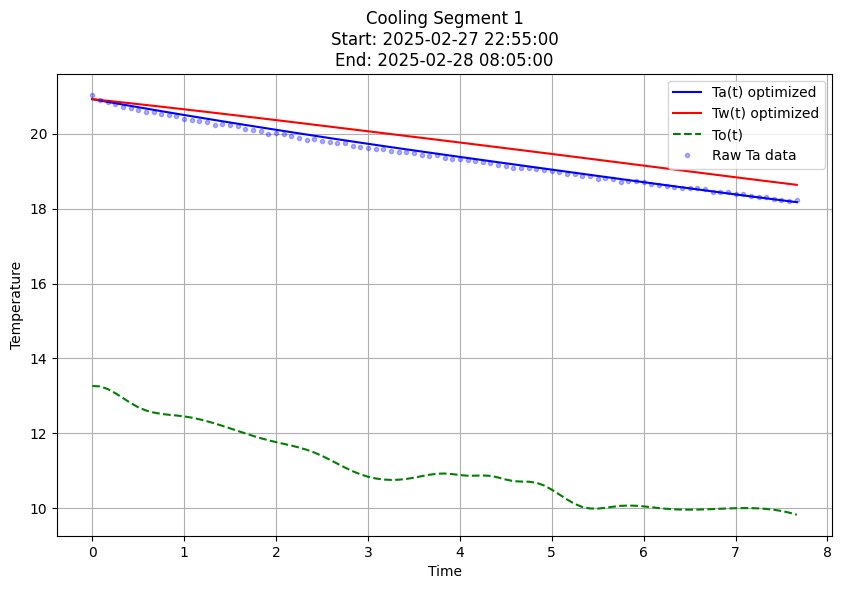

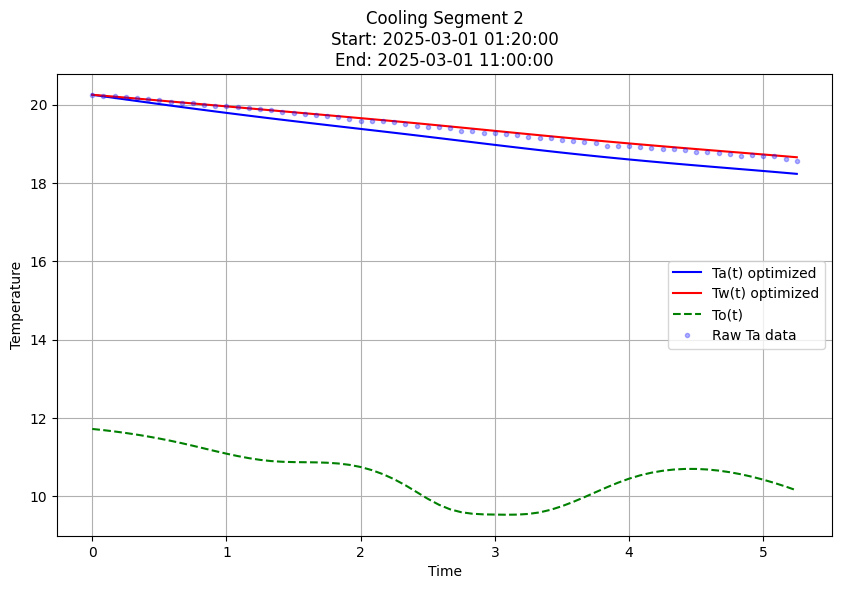

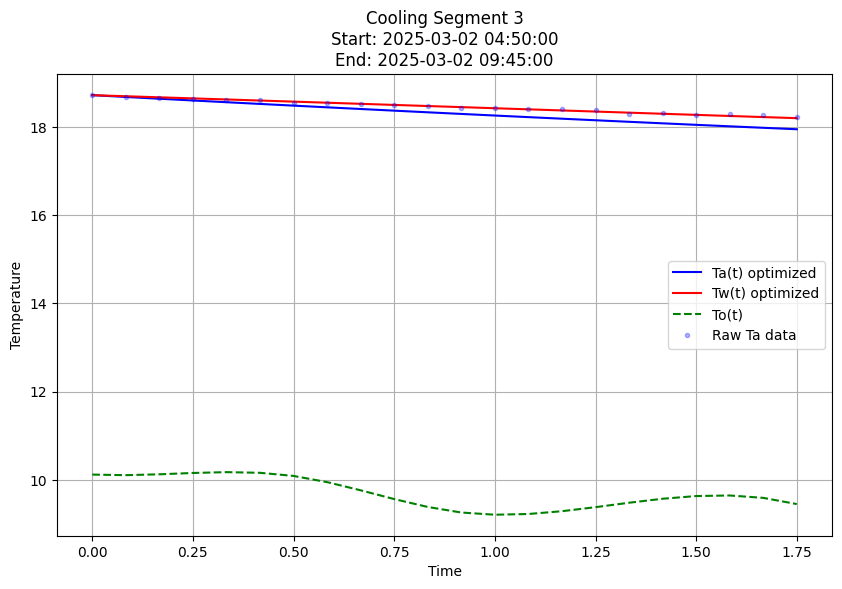

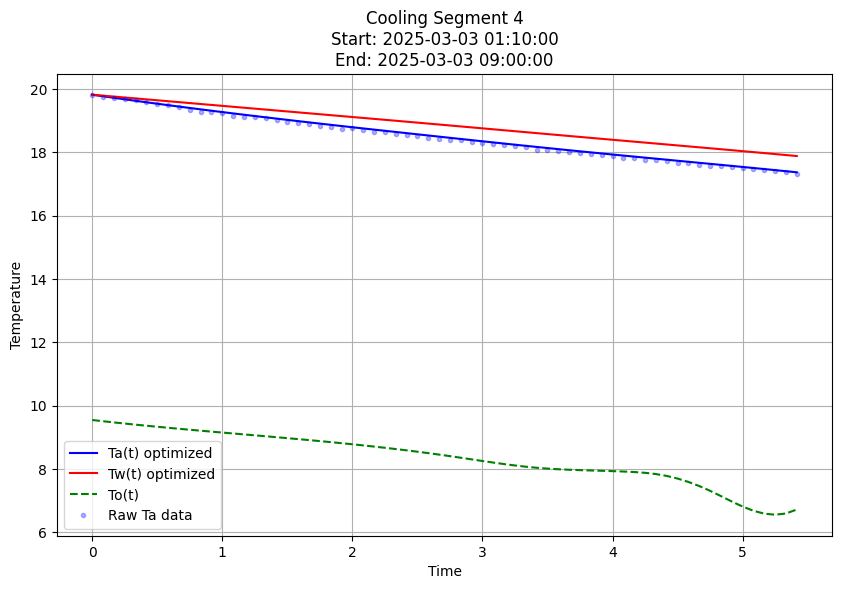

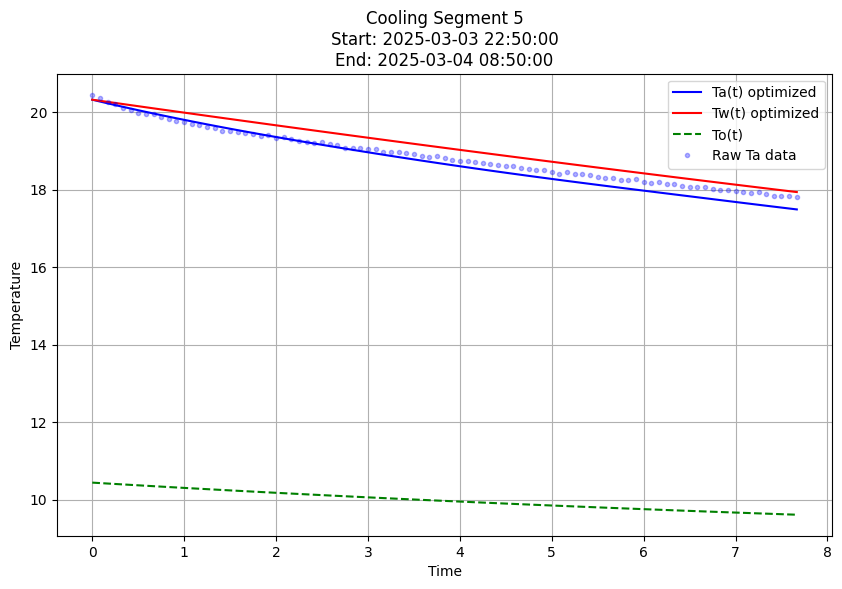

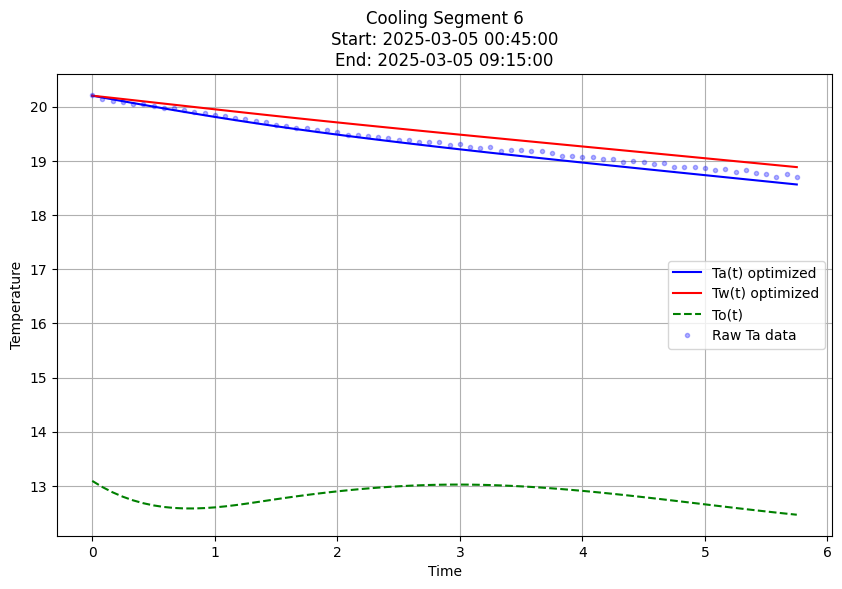

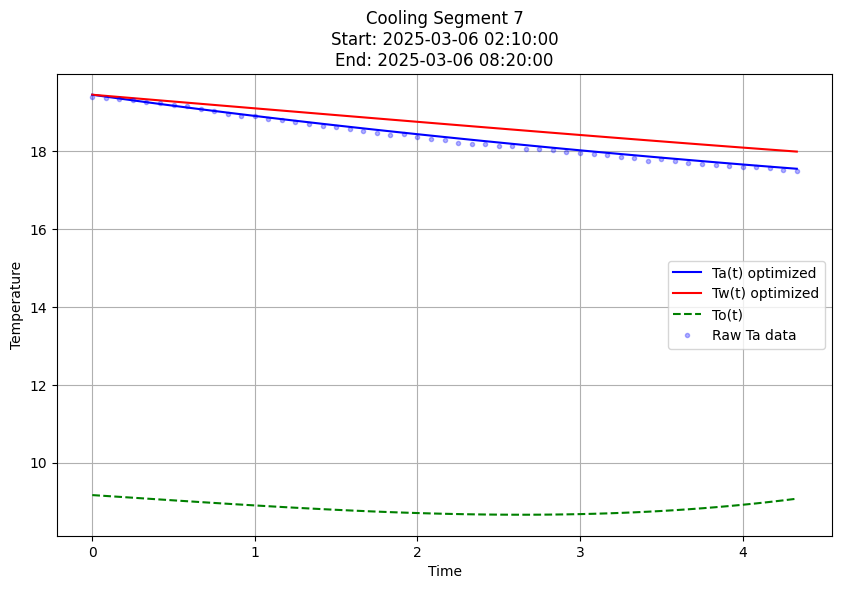

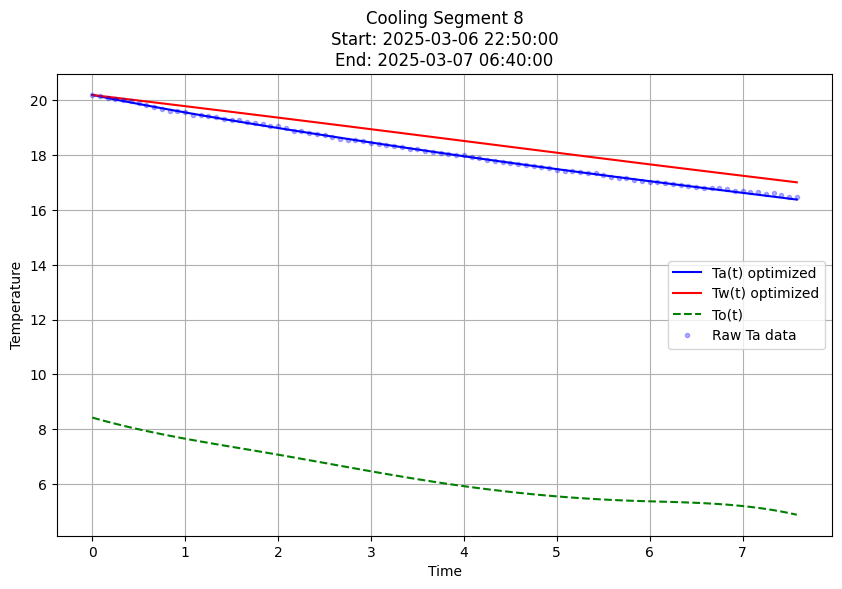

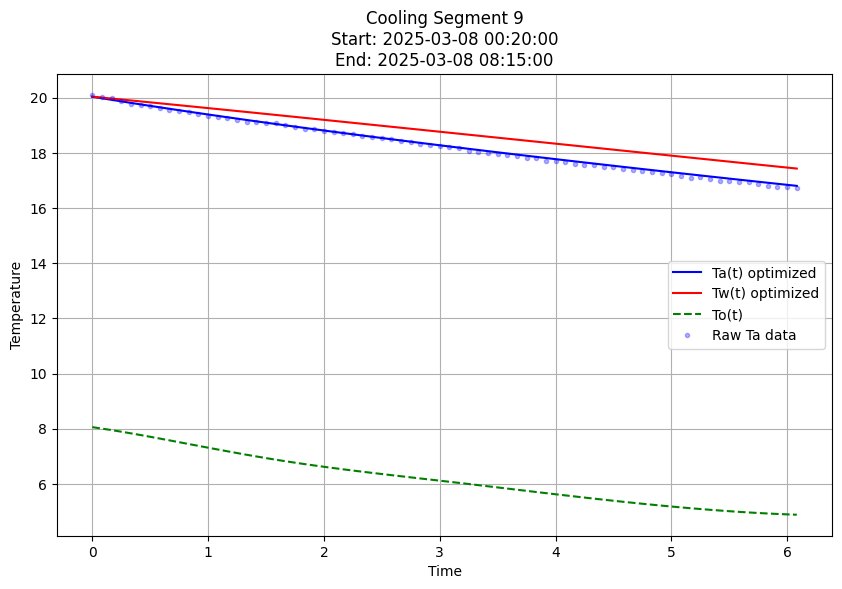

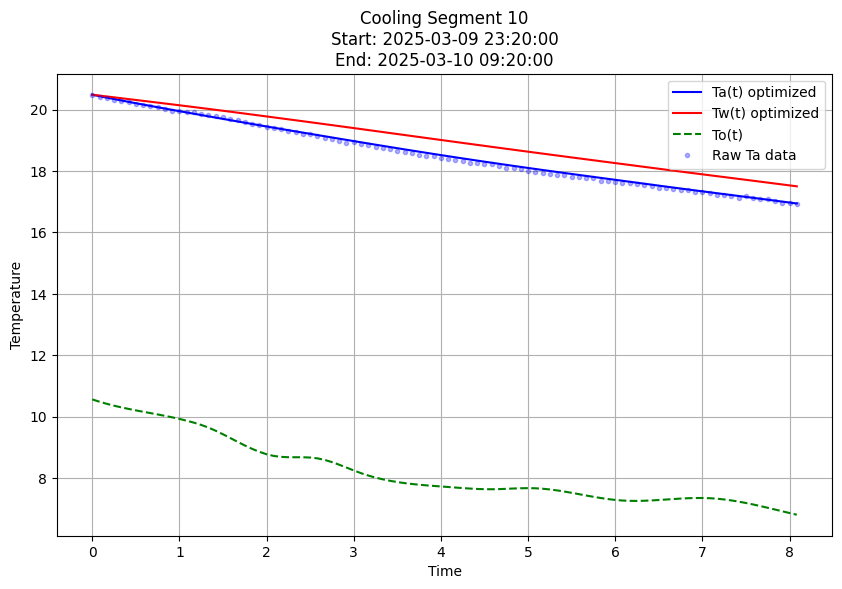

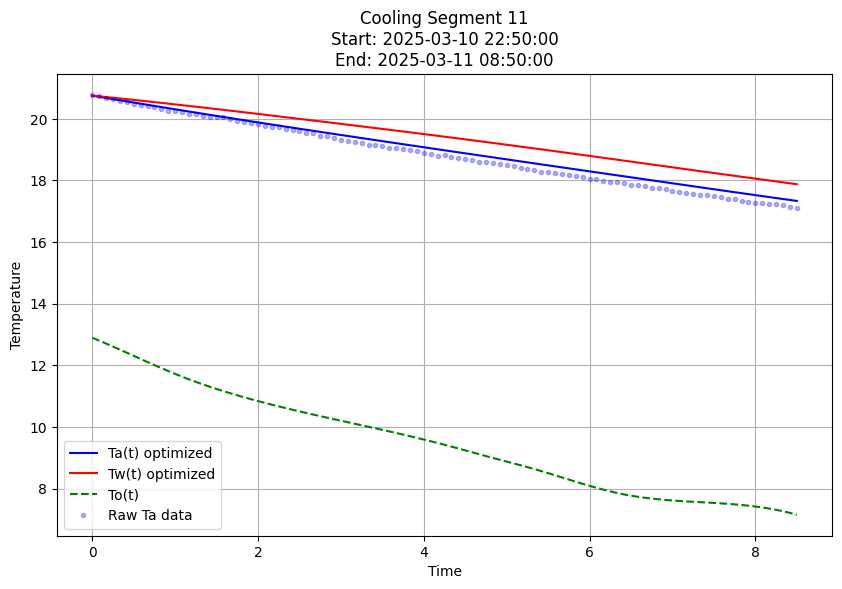

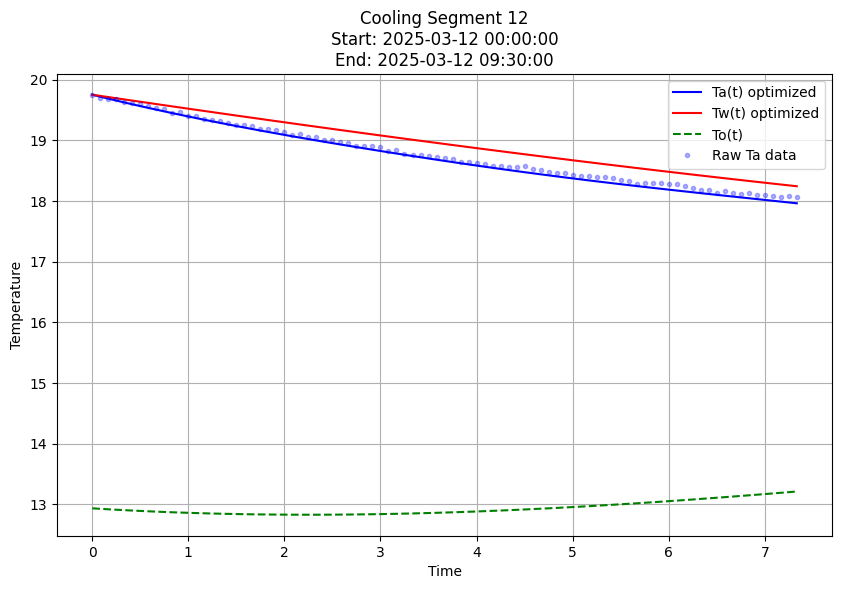

In [ ]:
optimize_cooling_system(segments_new[:9] + segments_new[10:], "New Door")

In [22]:
1./0.037471, 1./0.038444

(26.687304849083294, 26.011861408802414)

Precomputing data for segments...
Starting optimization with multiple initial points...
Calculating confidence intervals...

---Old Door---

Optimized parameters with 95% confidence intervals:
k1 = 0.897203 ± 1.110410
k2 = 0.072734 ± 36.425296
k3 = 0.038930 ± 69.318420

Goodness of fit:
R-squared = 0.9737

Generating plots...


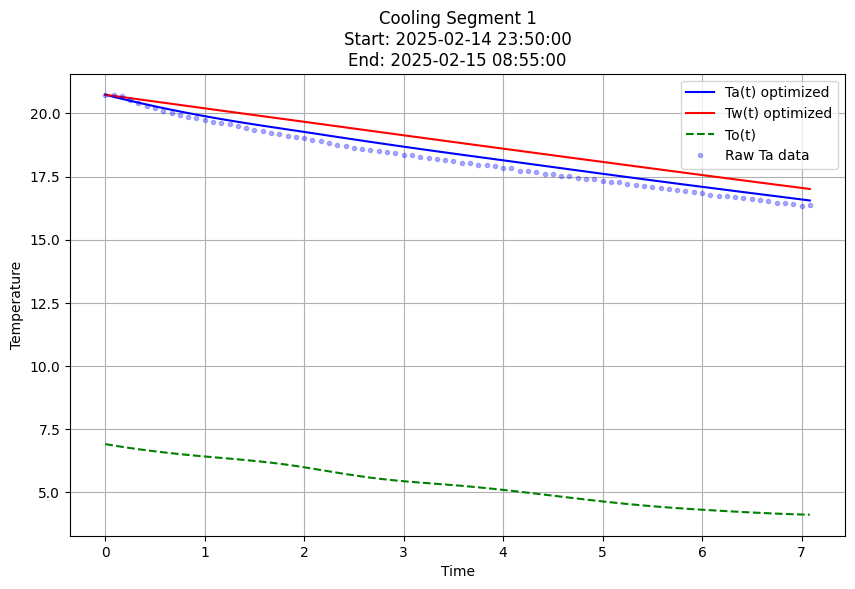

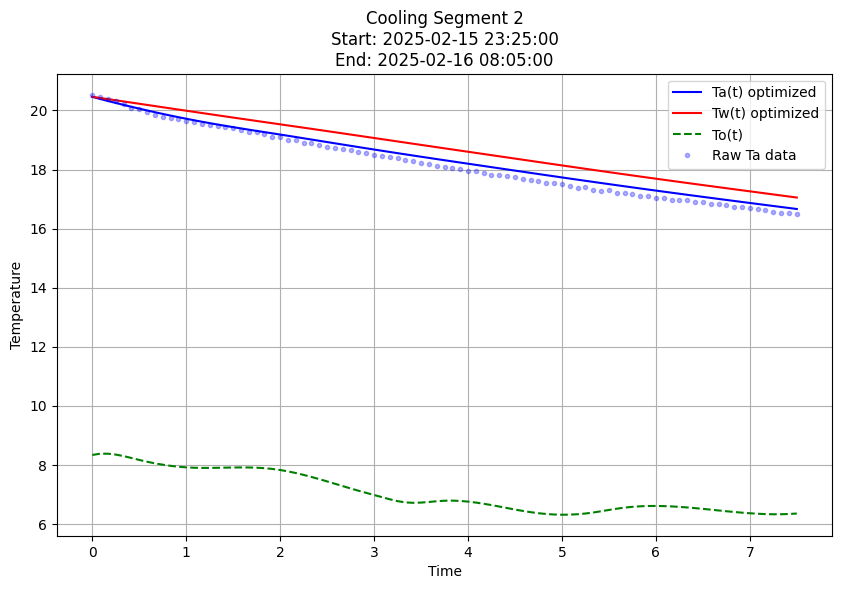

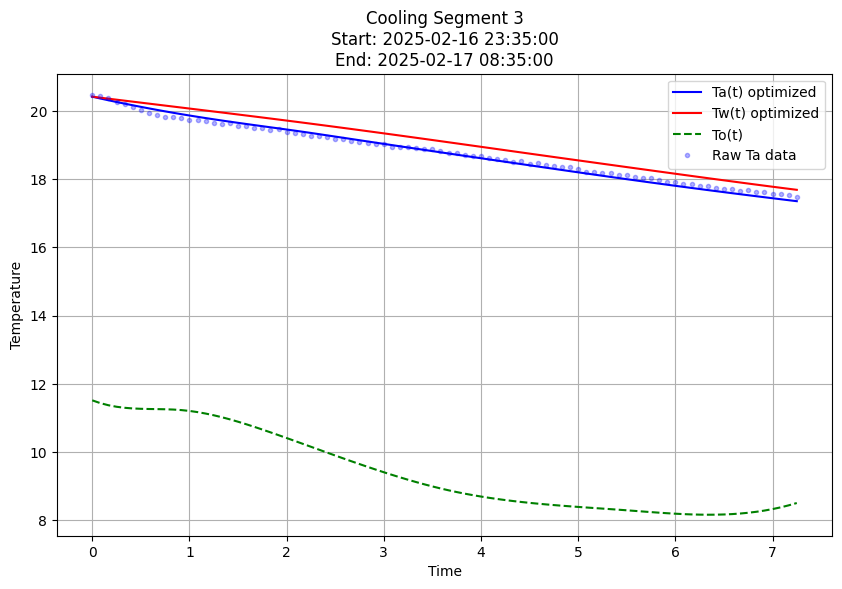

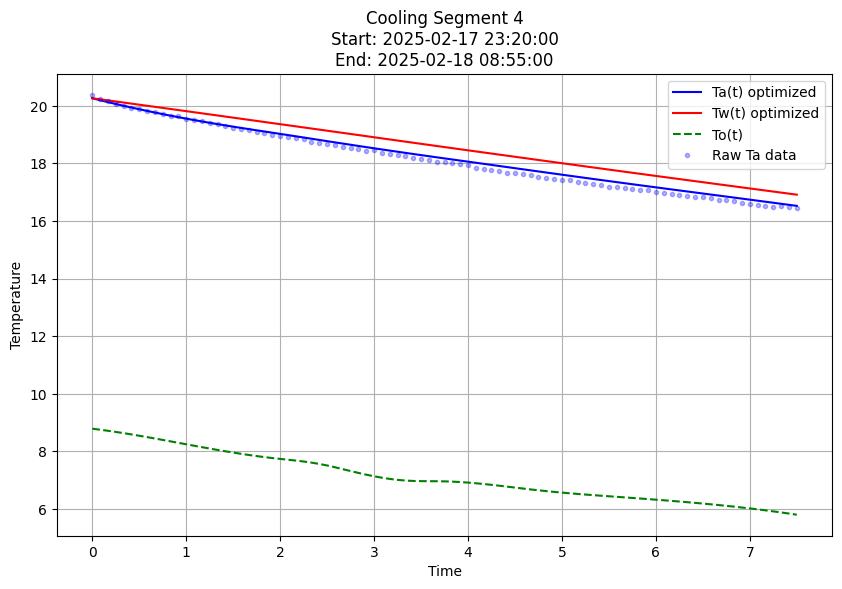

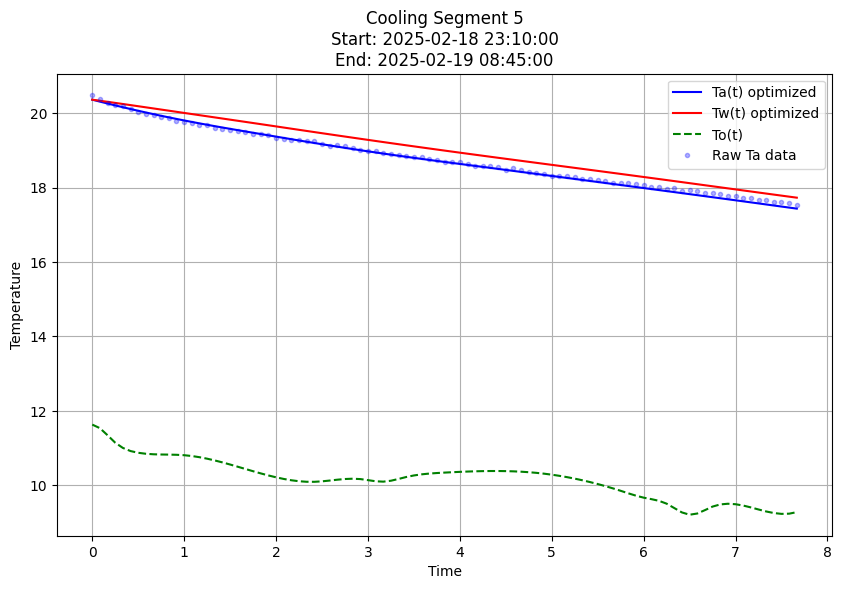

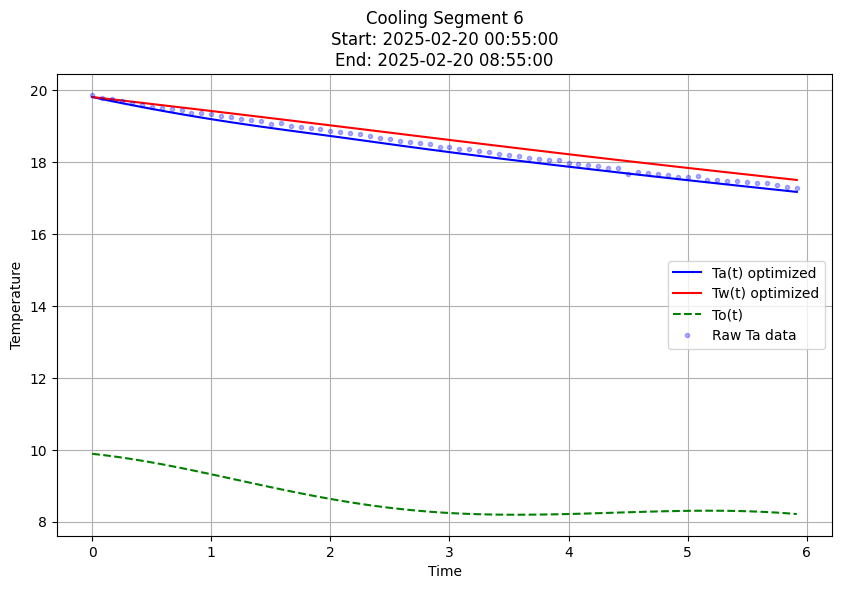

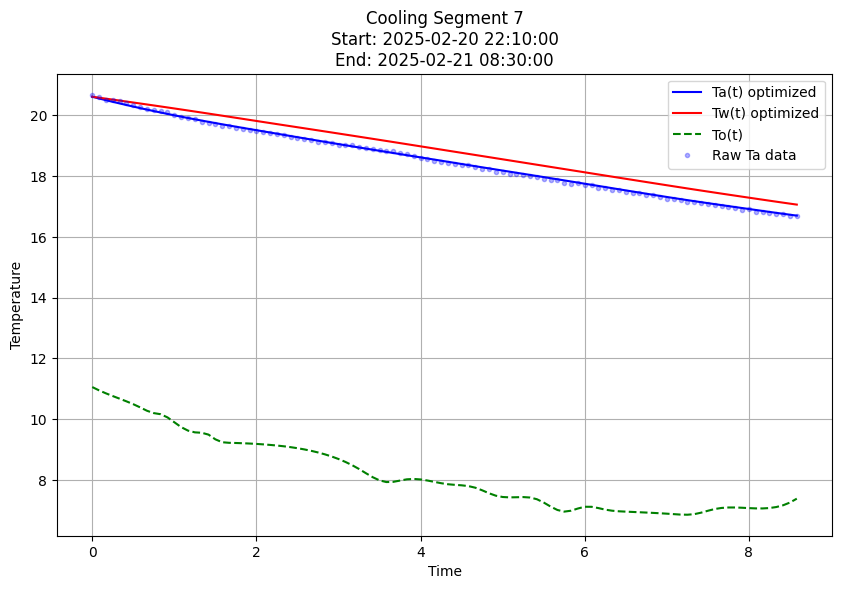

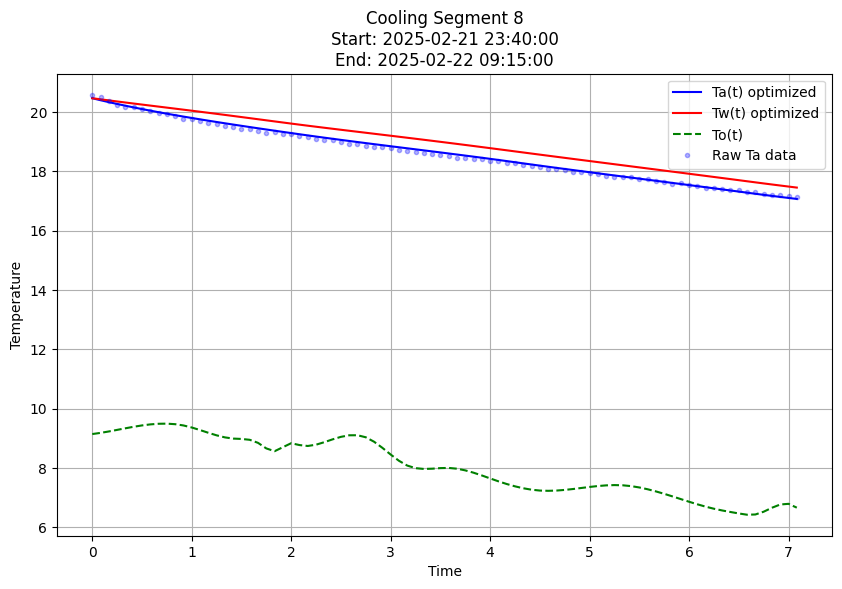

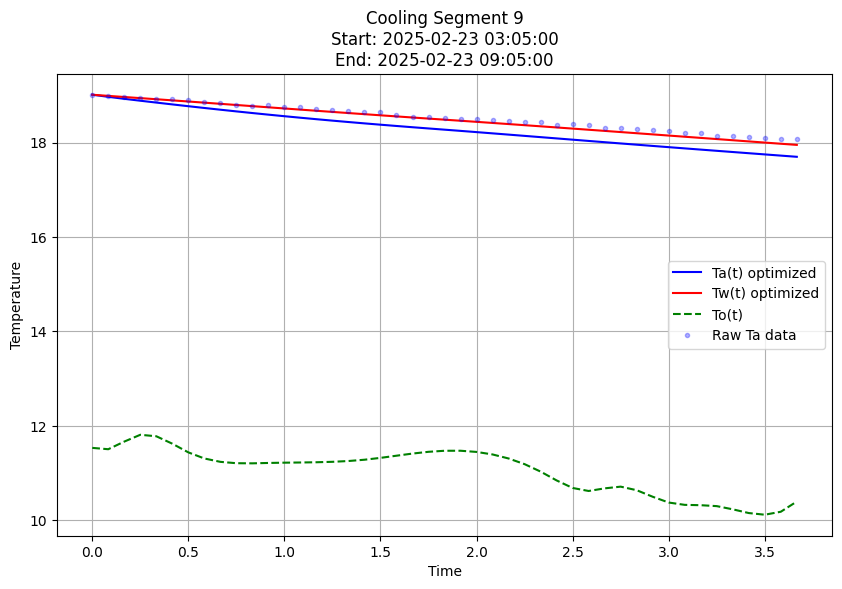

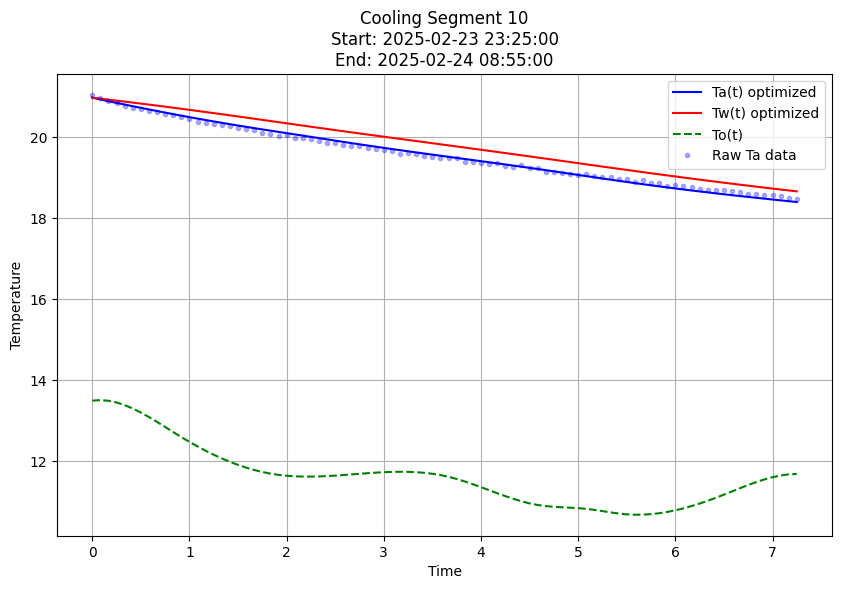

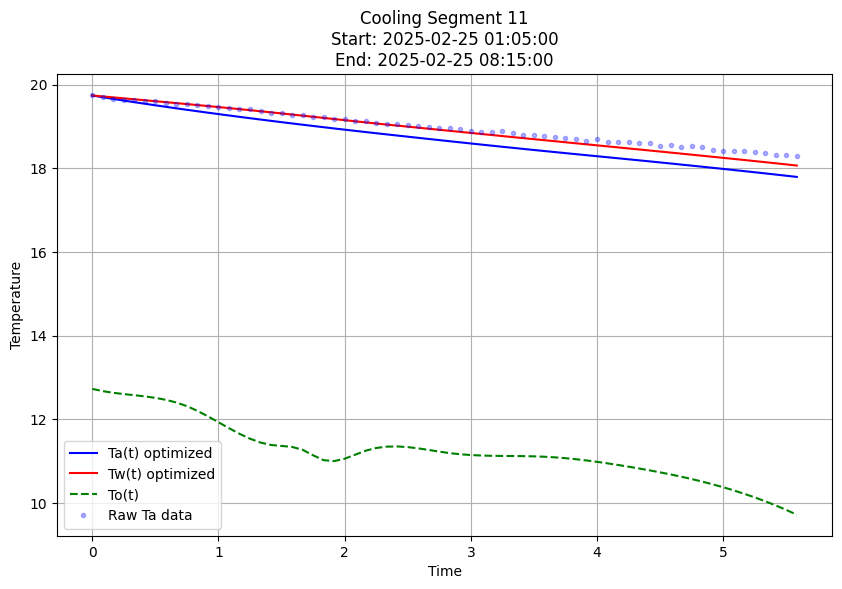

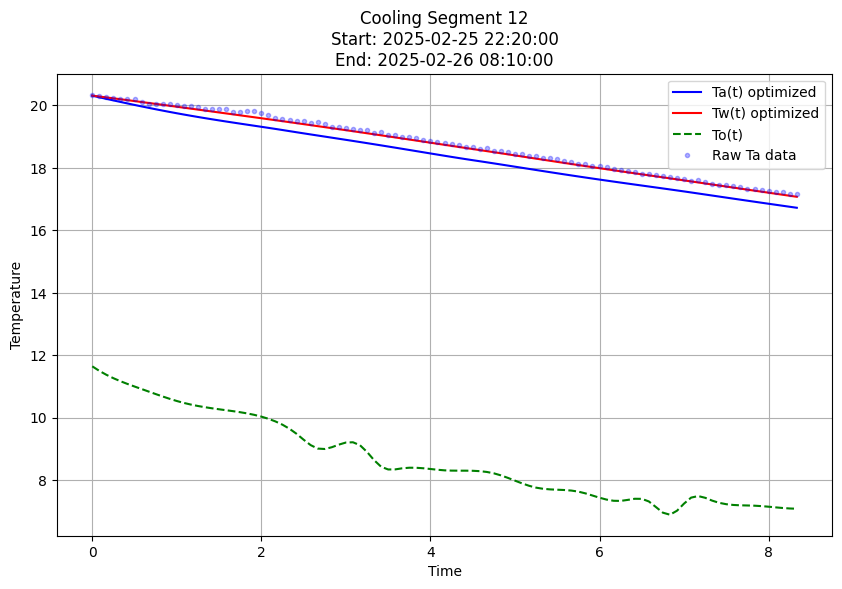

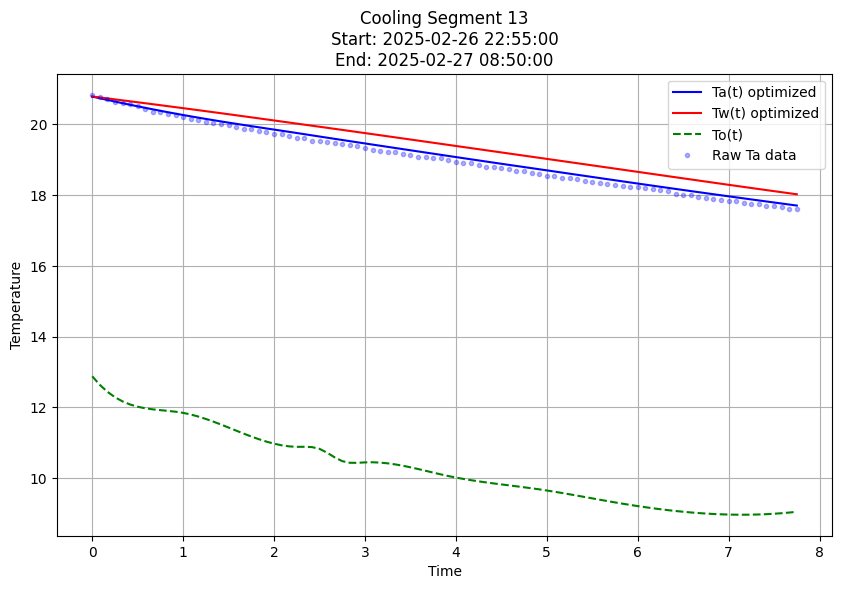

In [23]:
optimize_cooling_system(segments_old, "Old Door")

---
Optimize over selected constants:

In [65]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline
import time

# Select segments to use for optimization
if False: #True:    
    sup_title = "New Door"
    segments_to_optimize = segments_new[:9] + segments_new[10:]  #[:10]
else:
    sup_title = "Old Door"
    segments_to_optimize = segments_old

def cooling_system(t, y, k1, k2, k3, k4, To_func):
    """
    System of ODEs:
    Ta' = k1*(Tw - Ta) + k2*(To - Ta)
    Tw' = k3*(To - Tw) + k4*(Ta - Tw)
    """
    Ta, Tw = y
    To = To_func(t)
    dTa_dt = k1*(Tw - Ta) + k2*(To - Ta)
    dTw_dt = k3*(To - Tw) + k4*(Ta - Tw)
    return [dTa_dt, dTw_dt]

def objective(params, segments, precomputed_data=None, fixed_params=None):
    """
    Objective function that evaluates the fit across multiple segments
    params: list of parameters to optimize
    fixed_params: dict of fixed parameters {k1: value, k2: value, etc.}
    """
    # Combine fixed and optimized parameters
    k1, k2, k3, k4 = 0.0, 0.0, 0.0, 0.0  # default values
    if fixed_params:
        for key, value in fixed_params.items():
            if key == 'k1': k1 = value
            elif key == 'k2': k2 = value
            elif key == 'k3': k3 = value
            elif key == 'k4': k4 = value
    
    # Fill in optimized parameters
    param_idx = 0
    for i in range(4):
        param_name = f'k{i+1}'
        if not fixed_params or param_name not in fixed_params:
            if param_name == 'k1': k1 = params[param_idx]
            elif param_name == 'k2': k2 = params[param_idx]
            elif param_name == 'k3': k3 = params[param_idx]
            elif param_name == 'k4': k4 = params[param_idx]
            param_idx += 1
    
    total_error = 0
    total_points = 0
    
    for i, segment in enumerate(segments):
        if precomputed_data is not None:
            tm1, t1, t1_interp, t2_interp, Ta0, Tw0 = precomputed_data[i]
        else:
            tm1, t1, tm2, t2 = get_time_temps(segment)
            mask1 = ~np.isnan(t1)
            t1_interp = UnivariateSpline(tm1[mask1], t1[mask1], s=len(tm1)*0.001)
            mask2 = ~np.isnan(t2)
            t2_interp = UnivariateSpline(tm2[mask2], t2[mask2], s=len(tm2)*0.01)
            Ta0, Tw0 = t1_interp(0), t1_interp(0)
        
        solution = solve_ivp(
            cooling_system,
            (tm1[0], tm1[-1]),
            [Ta0, Tw0],
            args=(k1, k2, k3, k4, t2_interp),
            t_eval=tm1,
            method='RK45'
        )
        
        segment_error = np.mean((solution.y[0] - t1)**2)
        total_error += segment_error * len(tm1)
        total_points += len(tm1)
    
    return total_error / total_points

def optimize_cooling_system(segments_to_optimize, sup_title, fixed_params=None, plot_results=False):
    """
    Optimize cooling system parameters
    fixed_params: dict of fixed parameters {k1: value, k2: value, etc.}
    plot_results: bool, if True, plot the results
    """
    # Precompute data for all segments
    print("Precomputing data for segments...")
    precomputed_data = []
    for segment in segments_to_optimize:
        tm1, t1, tm2, t2 = get_time_temps(segment)
        mask1 = ~np.isnan(t1)
        t1_interp = UnivariateSpline(tm1[mask1], t1[mask1], s=len(tm1)*0.001)
        mask2 = ~np.isnan(t2)
        t2_interp = UnivariateSpline(tm2[mask2], t2[mask2], s=len(tm2)*0.01)
        Ta0, Tw0 = t1_interp(0), t1_interp(0)
        precomputed_data.append((tm1, t1, t1_interp, t2_interp, Ta0, Tw0))

    # Determine which parameters to optimize
    n_params = 4 - (len(fixed_params) if fixed_params else 0)
    if n_params == 0:
        print("No parameters to optimize!")
        return

    # Initial guess for parameters (scaled to be closer to 1)
    initial_guess = [10.*0.5/24., 1.4/24., 0.5/24., 0.0][:n_params]

    # Define bounds for parameters
    bounds = [(0, 1.0)] * n_params

    # Run multiple optimizations with different starting points
    print("Starting optimization with multiple initial points...")
    n_trials = 5
    best_result = None
    best_error = float('inf')

    for i in range(n_trials):
        # Generate random initial guess within bounds
        x0 = np.random.uniform(0, 1.0, n_params)
        
        result = minimize(
            objective,
            x0,
            args=(segments_to_optimize, precomputed_data, fixed_params),
            method='L-BFGS-B',
            bounds=bounds,
            options={'maxiter': 1000}
        )
        
        if result.fun < best_error:
            best_error = result.fun
            best_result = result

    result = best_result

    # Get optimized parameters
    optimized_params = result.x
    param_idx = 0
    k1, k2, k3, k4 = 0.0, 0.0, 0.0, 0.0
    
    # Combine fixed and optimized parameters
    if fixed_params:
        for key, value in fixed_params.items():
            if key == 'k1': k1 = value
            elif key == 'k2': k2 = value
            elif key == 'k3': k3 = value
            elif key == 'k4': k4 = value
    
    # Fill in optimized parameters
    for i in range(4):
        param_name = f'k{i+1}'
        if not fixed_params or param_name not in fixed_params:
            if param_name == 'k1': k1 = optimized_params[param_idx]
            elif param_name == 'k2': k2 = optimized_params[param_idx]
            elif param_name == 'k3': k3 = optimized_params[param_idx]
            elif param_name == 'k4': k4 = optimized_params[param_idx]
            param_idx += 1

    # Calculate confidence intervals using the Hessian matrix
    print("Calculating confidence intervals...")
    hessian = result.hess_inv.todense()
    covariance = np.linalg.inv(hessian)
    std_errors = np.sqrt(np.diag(covariance))
    confidence_intervals = 1.96 * std_errors

    result_dict = {}

    print("\n---" + sup_title + "---")
    print(f"\nParameters:")
    param_idx = 0
    for i in range(4):
        param_name = f'k{i+1}'
        if fixed_params and param_name in fixed_params:
            print(f"{param_name} = {fixed_params[param_name]:.6f} (fixed)")
            result_dict[param_name] = fixed_params[param_name]
        else:
            print(f"{param_name} = {optimized_params[param_idx]:.6f} ± {confidence_intervals[param_idx]:.6f}")
            result_dict[param_name] = float(optimized_params[param_idx])
            param_idx += 1

    # Calculate R-squared value
    total_error = objective(result.x, segments_to_optimize, precomputed_data, fixed_params)
    total_variance = np.var(np.concatenate([seg['temp1'].values for seg in segments_to_optimize]))
    r_squared = 1 - (total_error / total_variance)

    print(f"\nGoodness of fit:")
    print(f"R-squared = {r_squared:.4f}")

    result_dict['R-squared'] = float(r_squared)
    # Plot results for each segment
    if plot_results:
        print("\nGenerating plots...")
        for i, segment in enumerate(segments_to_optimize):
            tm1, t1, t1_interp, t2_interp, Ta0, Tw0 = precomputed_data[i]
            
            solution_opt = solve_ivp(
                cooling_system,
                (tm1[0], tm1[-1]),
                [Ta0, Tw0],
                args=(k1, k2, k3, k4, t2_interp),
                t_eval=tm1,
                method='RK45'
            )
            
            plt.figure(figsize=(10, 6))
            plt.plot(solution_opt.t, solution_opt.y[0], 'b-', label='Ta(t) optimized')
            plt.plot(solution_opt.t, solution_opt.y[1], 'r-', label='Tw(t) optimized')
            plt.plot(tm1, t2_interp(tm1), 'g--', label='To(t)')
            plt.plot(tm1, t1, 'b.', alpha=0.3, label='Raw Ta data')
            plt.title(f'Cooling Segment {i+1}\n'
                        f'Start: {segment["start_time"]}\n'
                        f'End: {segment["end_time"]}')
            plt.xlabel('Time')
            plt.ylabel('Temperature')
            plt.legend()
            plt.grid(True)
            plt.show()


    # --- Inefficient way to plot parametric curves: ---    
    # Create a single figure for parametric curves
    plt.figure(figsize=(10, 6))

    # Generate unique colors for each segment
    colors = plt.cm.tab10(np.linspace(0, 1, len(segments_to_optimize)))

    for i, segment in enumerate(segments_to_optimize):
        tm1, t1, t1_interp, t2_interp, Ta0, Tw0 = precomputed_data[i]
        
        solution_opt = solve_ivp(
            cooling_system,
            (tm1[0], tm1[-1]),
            [Ta0, Tw0],
            args=(k1, k2, k3, k4, t2_interp),
            t_eval=tm1,
            method='RK45'
        )
        
        # Calculate derivative of Ta(t)
        dt = tm1[1] - tm1[0]  # time step
        dTa_dt = np.gradient(solution_opt.y[0], dt)
        
        # Calculate temperature difference
        temp_diff = solution_opt.y[0] - t2_interp(tm1)
        
        # Plot parametric curve
        plt.plot(-dTa_dt[3:], temp_diff[3:], '-', color=colors[i], 
                label=f'Segment {i+1}',
                alpha=0.7)

    x = np.linspace(0.0*np.min(-dTa_dt[1:]), 1.0*np.max(-dTa_dt[1:]), 100)

    A0 = 1./result_dict['k3']
    plt.plot(x, A0*x, '--', color='black', label=f'{A0:.3f}*x')
    
    plt.xlim(0, None)
    plt.ylim(0, None)
    plt.xlabel('dTa/dt (°C/s)')
    plt.ylabel('Ta - To (°C)')
    plt.title(sup_title + ': Parametric Curves: Temperature Difference vs Rate of Change')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    # ---
    
    return result_dict

# Example usage:
# To optimize all parameters:
# optimize_cooling_system(segments_to_optimize, sup_title)

# To fix k4 and optimize others:
# optimize_cooling_system(segments_to_optimize, sup_title, fixed_params={'k4': 0.0})

# To fix k1 and k4 and optimize others:
# optimize_cooling_system(segments_to_optimize, sup_title, fixed_params={'k1': 0.2, 'k4': 0.0})

Precomputing data for segments...
Starting optimization with multiple initial points...
Calculating confidence intervals...

---Old Door---

Parameters:
k1 = 0.700000 (fixed)
k2 = 0.070000 (fixed)
k3 = 0.037489 ± 76.545656
k4 = 0.000000 (fixed)

Goodness of fit:
R-squared = 0.9737


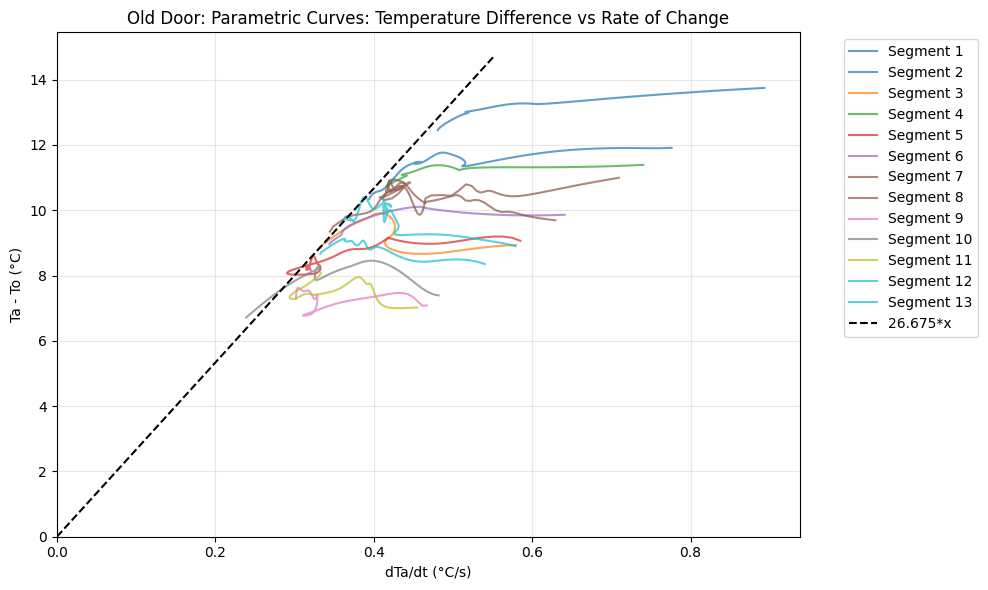

In [66]:
results = optimize_cooling_system(segments_old, "Old Door", fixed_params={'k1': 0.7,'k2': 0.07, 'k4': 0.0}) #'k1': 0.7, 'k2': 0.07, 'k4': 0.0})

In [61]:
results


{'k1': 10.0,
 'k2': 1.0,
 'k3': np.float64(0.026042815267062466),
 'k4': 0.0,
 'R-squared': np.float64(0.8851349342115891)}

Precomputing data for segments...
Starting optimization with multiple initial points...
Calculating confidence intervals...

---New Door---

Parameters:
k1 = 0.700000 (fixed)
k2 = 0.070000 (fixed)
k3 = 0.034645 ± 69.147330
k4 = 0.000000 (fixed)

Goodness of fit:
R-squared = 0.9836


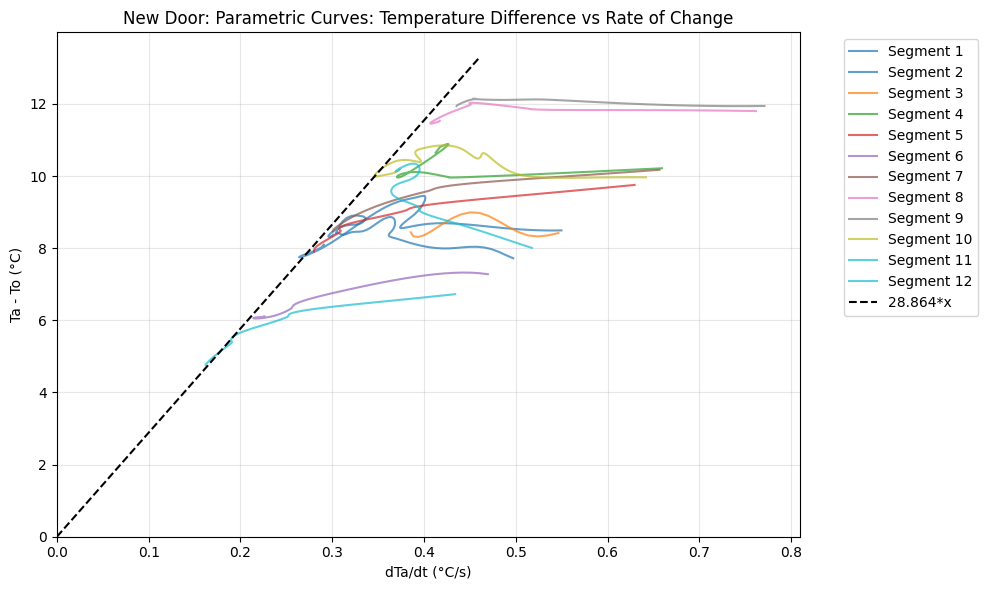

{'k1': 0.7,
 'k2': 0.07,
 'k3': 0.03464483720798122,
 'k4': 0.0,
 'R-squared': 0.9836373935403208}

In [67]:
optimize_cooling_system(segments_new[:9] + segments_new[10:], "New Door", fixed_params={'k1': 0.7, 'k2': 0.07, 'k4': 0.0})

Running grid search...
Precomputing data for segments...
Starting optimization with multiple initial points...
Calculating confidence intervals...

---Old Door---

Parameters:
k1 = 1.000000 (fixed)
k2 = 0.100000 (fixed)
k3 = 0.033162 ± 85.523666
k4 = 0.000000 (fixed)

Goodness of fit:
R-squared = 0.9668
Precomputing data for segments...
Starting optimization with multiple initial points...
Calculating confidence intervals...

---Old Door---

Parameters:
k1 = 1.000000 (fixed)
k2 = 0.090000 (fixed)
k3 = 0.035495 ± 83.867450
k4 = 0.000000 (fixed)

Goodness of fit:
R-squared = 0.9704
Precomputing data for segments...
Starting optimization with multiple initial points...
Calculating confidence intervals...

---Old Door---

Parameters:
k1 = 1.000000 (fixed)
k2 = 0.080000 (fixed)
k3 = 0.037972 ± 84.880043
k4 = 0.000000 (fixed)

Goodness of fit:
R-squared = 0.9733
Precomputing data for segments...
Starting optimization with multiple initial points...
Calculating confidence intervals...

---Old

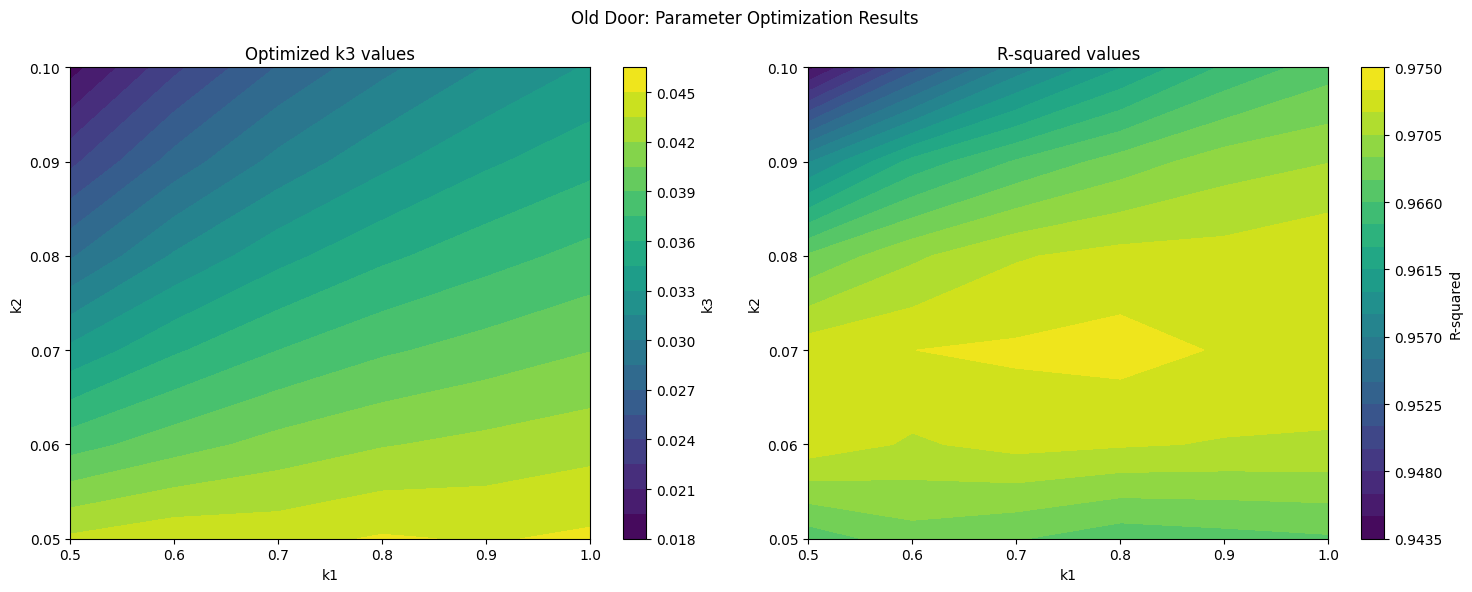


Old Door Best parameter combination:
k1 = 0.800000
k2 = 0.070000
k3 = 0.038759
R-squared = 0.974090

Old Door Best parameters: {'k1': 0.8, 'k2': 0.07, 'k4': 0.0}


In [30]:
segments, title = segments_old, "Old Door"

# Create lists of k1 and k2 values to try
k1_values = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
k2_values = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05]

# Initialize results list
results = []

max_r_squared = 0.0

# Run optimization for each combination
print("Running grid search...")
for k1 in k1_values:
    row_results = []
    for k2 in k2_values:
        fixed_params = {'k1': k1, 'k2': k2, 'k4': 0.0}
        result = optimize_cooling_system(segments, title, fixed_params=fixed_params, plot_results=False)
        row_results.append(result)
        if result['R-squared'] > max_r_squared:
            max_r_squared = result['R-squared']
            best_params = fixed_params
    results.append(row_results)

# Extract k3 and R-squared values into grids
k3_grid = np.array([[result['k3'] for result in row] for row in results])
r_squared_grid = np.array([[result['R-squared'] for result in row] for row in results])

# Create contour plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Create meshgrid for plotting
k1_mesh, k2_mesh = np.meshgrid(k1_values, k2_values, indexing='ij')

# Plot k3 contour
contour1 = ax1.contourf(k1_mesh, k2_mesh, k3_grid, levels=20)
ax1.set_xlabel('k1')
ax1.set_ylabel('k2')
ax1.set_title('Optimized k3 values')
plt.colorbar(contour1, ax=ax1, label='k3')

# Plot R-squared contour
contour2 = ax2.contourf(k1_mesh, k2_mesh, r_squared_grid, levels=20)
ax2.set_xlabel('k1')
ax2.set_ylabel('k2')
ax2.set_title('R-squared values')
plt.colorbar(contour2, ax=ax2, label='R-squared')

plt.suptitle(f'{title}: Parameter Optimization Results')
plt.tight_layout()
plt.show()

# Print the best combination
best_idx = np.unravel_index(np.argmax(r_squared_grid), r_squared_grid.shape)
best_k1 = k1_values[best_idx[0]]
best_k2 = k2_values[best_idx[1]]
best_k3 = k3_grid[best_idx]
best_r_squared = r_squared_grid[best_idx]

print(f"\n{title} Best parameter combination:")
print(f"k1 = {best_k1:.6f}")
print(f"k2 = {best_k2:.6f}")
print(f"k3 = {best_k3:.6f}")
print(f"R-squared = {best_r_squared:.6f}")

print(f"\n{title} Best parameters: {best_params}")

In [38]:
1./0.038759

25.800459248174615

Running grid search...
Precomputing data for segments...
Starting optimization with multiple initial points...
Calculating confidence intervals...

---New Door---

Parameters:
k1 = 1.000000 (fixed)
k2 = 0.100000 (fixed)
k3 = 0.030469 ± 76.718452
k4 = 0.000000 (fixed)

Goodness of fit:
R-squared = 0.9707
Precomputing data for segments...
Starting optimization with multiple initial points...
Calculating confidence intervals...

---New Door---

Parameters:
k1 = 1.000000 (fixed)
k2 = 0.090000 (fixed)
k3 = 0.032922 ± 76.329969
k4 = 0.000000 (fixed)

Goodness of fit:
R-squared = 0.9777
Precomputing data for segments...
Starting optimization with multiple initial points...
Calculating confidence intervals...

---New Door---

Parameters:
k1 = 1.000000 (fixed)
k2 = 0.080000 (fixed)
k3 = 0.035413 ± 76.081171
k4 = 0.000000 (fixed)

Goodness of fit:
R-squared = 0.9823
Precomputing data for segments...
Starting optimization with multiple initial points...
Calculating confidence intervals...

---New

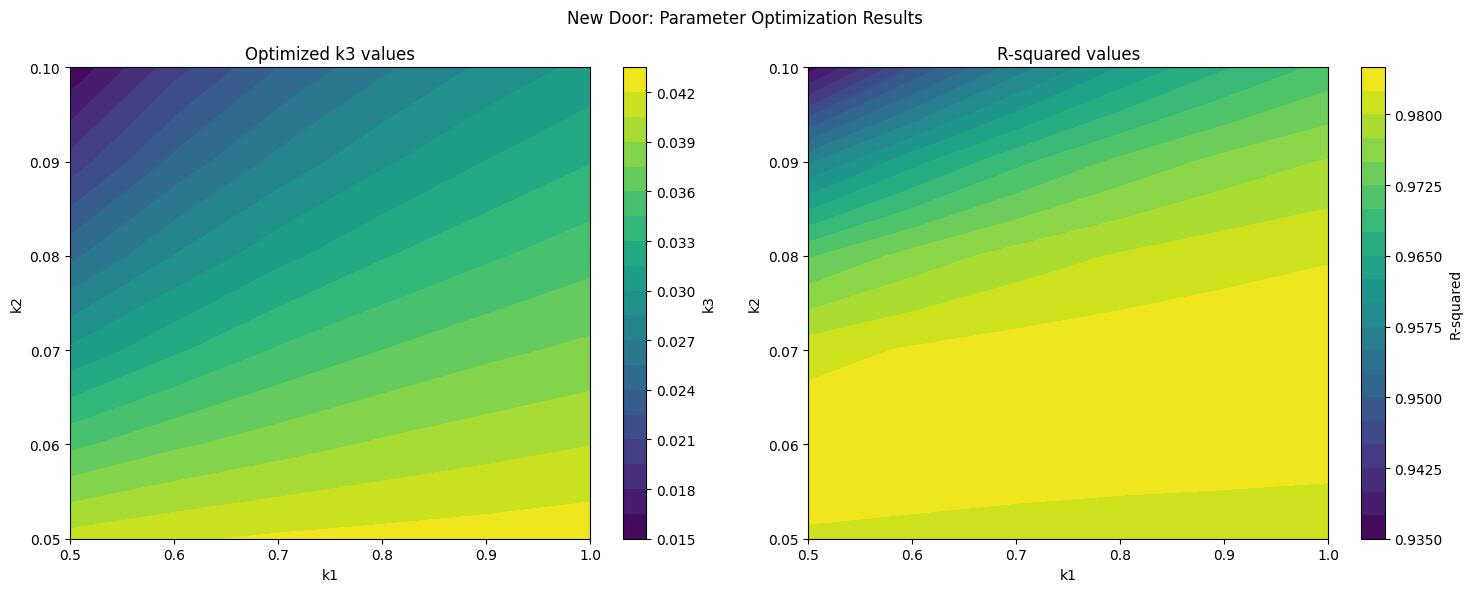


New Door Best parameter combination:
k1 = 0.500000
k2 = 0.060000
k3 = 0.035605
R-squared = 0.984746

New Door Best parameters: {'k1': 0.5, 'k2': 0.06, 'k4': 0.0}


In [29]:
segments, title = segments_new[:9] + segments_new[10:], "New Door"

# Create lists of k1 and k2 values to try
k1_values = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
k2_values = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05]

# Initialize results list
results = []

max_r_squared = 0.0

# Run optimization for each combination
print("Running grid search...")
for k1 in k1_values:
    row_results = []
    for k2 in k2_values:
        fixed_params = {'k1': k1, 'k2': k2, 'k4': 0.0}
        result = optimize_cooling_system(segments, title, fixed_params=fixed_params, plot_results=False)
        row_results.append(result)
        if result['R-squared'] > max_r_squared:
            max_r_squared = result['R-squared']
            best_params = fixed_params
    results.append(row_results)

# Extract k3 and R-squared values into grids
k3_grid = np.array([[result['k3'] for result in row] for row in results])
r_squared_grid = np.array([[result['R-squared'] for result in row] for row in results])

# Create contour plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Create meshgrid for plotting
k1_mesh, k2_mesh = np.meshgrid(k1_values, k2_values, indexing='ij')

# Plot k3 contour
contour1 = ax1.contourf(k1_mesh, k2_mesh, k3_grid, levels=20)
ax1.set_xlabel('k1')
ax1.set_ylabel('k2')
ax1.set_title('Optimized k3 values')
plt.colorbar(contour1, ax=ax1, label='k3')

# Plot R-squared contour
contour2 = ax2.contourf(k1_mesh, k2_mesh, r_squared_grid, levels=20)
ax2.set_xlabel('k1')
ax2.set_ylabel('k2')
ax2.set_title('R-squared values')
plt.colorbar(contour2, ax=ax2, label='R-squared')

plt.suptitle(f'{title}: Parameter Optimization Results')
plt.tight_layout()
plt.show()

# Print the best combination
best_idx = np.unravel_index(np.argmax(r_squared_grid), r_squared_grid.shape)
best_k1 = k1_values[best_idx[0]]
best_k2 = k2_values[best_idx[1]]
best_k3 = k3_grid[best_idx]
best_r_squared = r_squared_grid[best_idx]

print(f"\n{title} Best parameter combination:")
print(f"k1 = {best_k1:.6f}")
print(f"k2 = {best_k2:.6f}")
print(f"k3 = {best_k3:.6f}")
print(f"R-squared = {best_r_squared:.6f}")

print(f"\n{title} Best parameters: {best_params}")

In [37]:
1./0.035605

28.08594298553574

In [31]:
fixed_params = {'k1': 0.7, 'k2': 0.07, 'k4': 0.0}
segments, title = segments_new[:9] + segments_new[10:], "New Door"
result = optimize_cooling_system(segments, title, fixed_params=fixed_params, plot_results=False)
result

Precomputing data for segments...
Starting optimization with multiple initial points...
Calculating confidence intervals...

---New Door---

Parameters:
k1 = 0.700000 (fixed)
k2 = 0.070000 (fixed)
k3 = 0.034645 ± 69.175829
k4 = 0.000000 (fixed)

Goodness of fit:
R-squared = 0.9836


{'k1': 0.7,
 'k2': 0.07,
 'k3': 0.034644832465153756,
 'k4': 0.0,
 'R-squared': 0.9836373935403063}

In [41]:
fixed_params = {'k1': 0.8, 'k2': 0.07, 'k4': 0.0}
segments, title = segments_old, "Old Door"
result = optimize_cooling_system(segments, title, fixed_params=fixed_params, plot_results=False)
result

Precomputing data for segments...
Starting optimization with multiple initial points...
Calculating confidence intervals...

---Old Door---

Parameters:
k1 = 0.800000 (fixed)
k2 = 0.070000 (fixed)
k3 = 0.038759 ± 80.434541
k4 = 0.000000 (fixed)

Goodness of fit:
R-squared = 0.9741


{'k1': 0.8,
 'k2': 0.07,
 'k3': 0.03875927491701129,
 'k4': 0.0,
 'R-squared': 0.9740902155490911}

In [33]:
1./0.034644832465153756, 1./0.037488821144722975

(28.86433354832394, 26.6746184453112)

Precomputing data for segments...
Starting optimization with multiple initial points...
Calculating confidence intervals...

---New Door---

Parameters:
k1 = 0.500000 (fixed)
k2 = 0.060000 (fixed)
k3 = 0.035605 ± 60.907828
k4 = 0.000000 (fixed)

Goodness of fit:
R-squared = 0.9847

Generating plots...


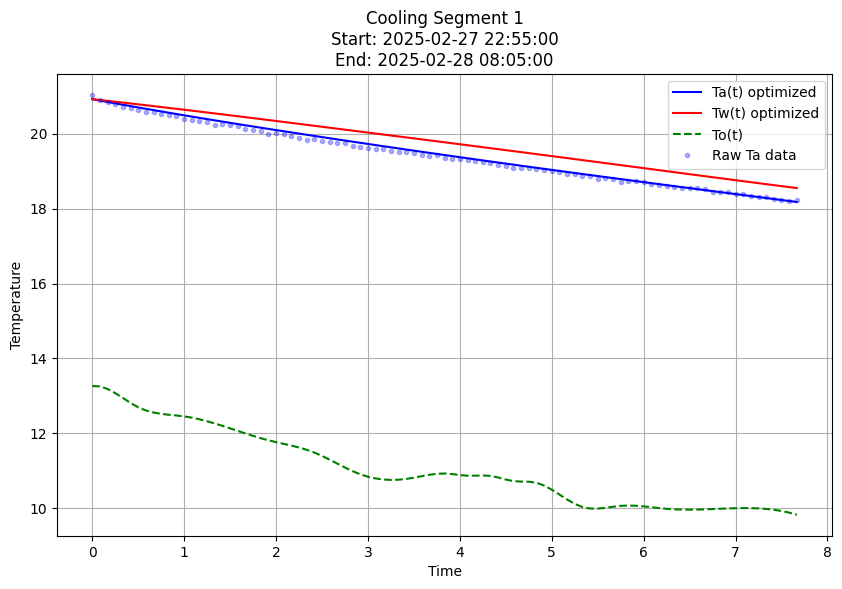

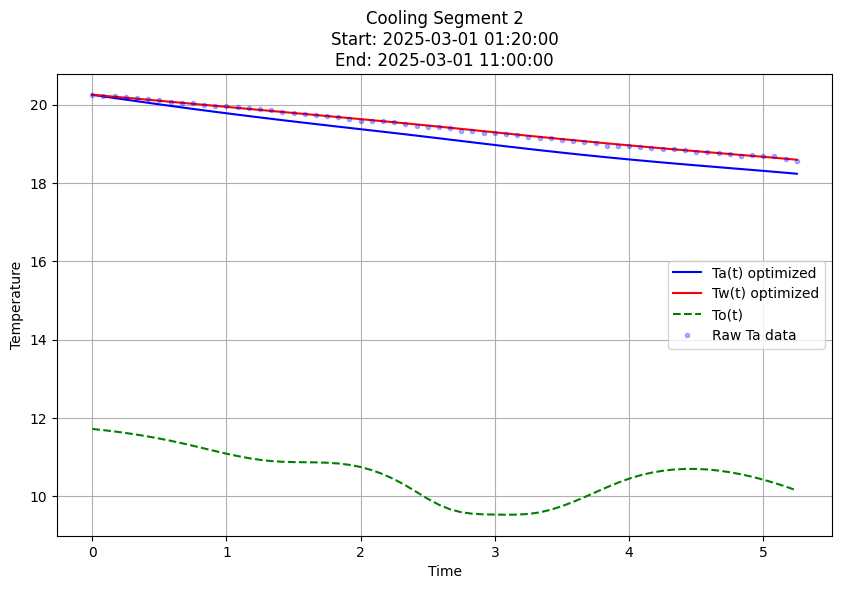

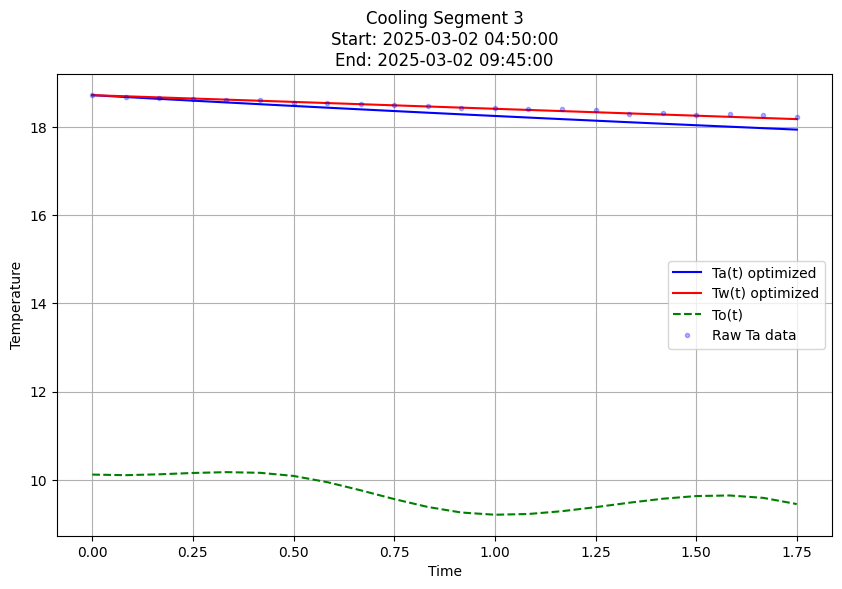

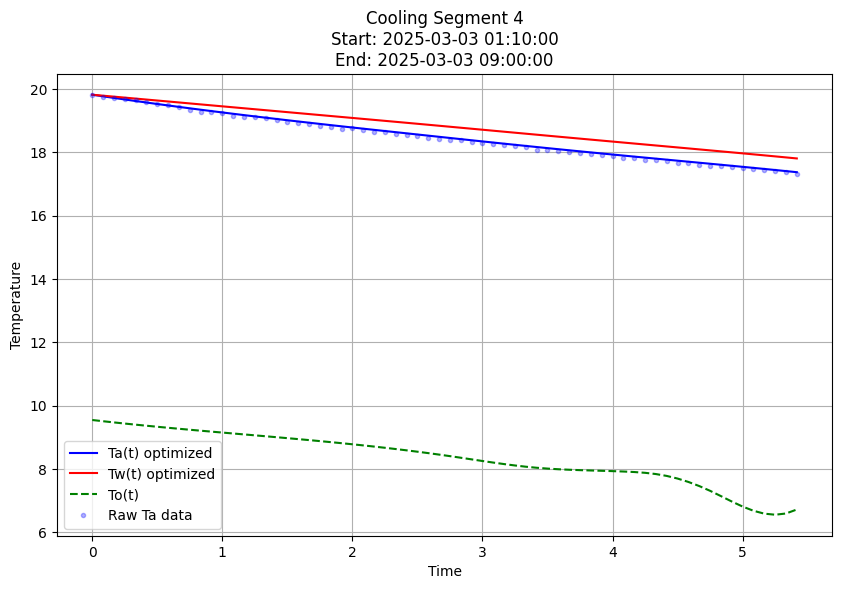

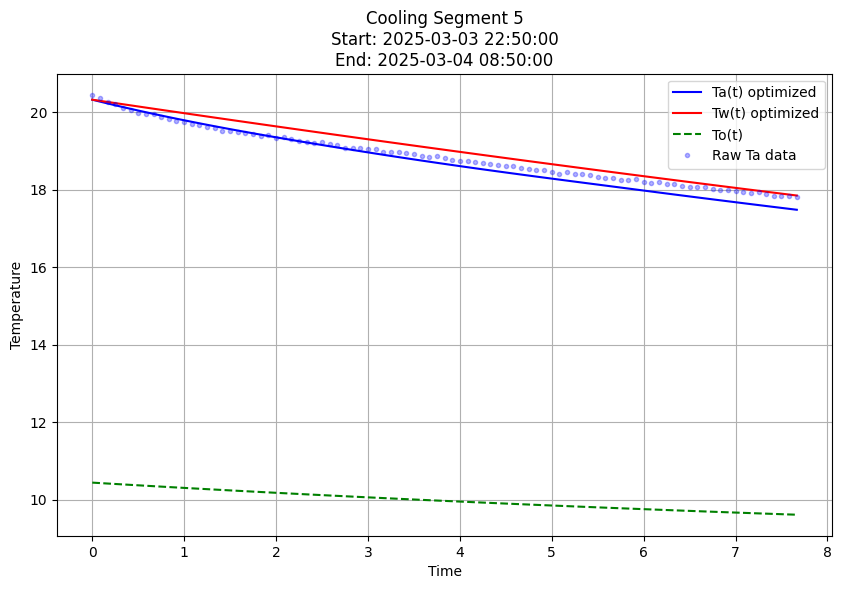

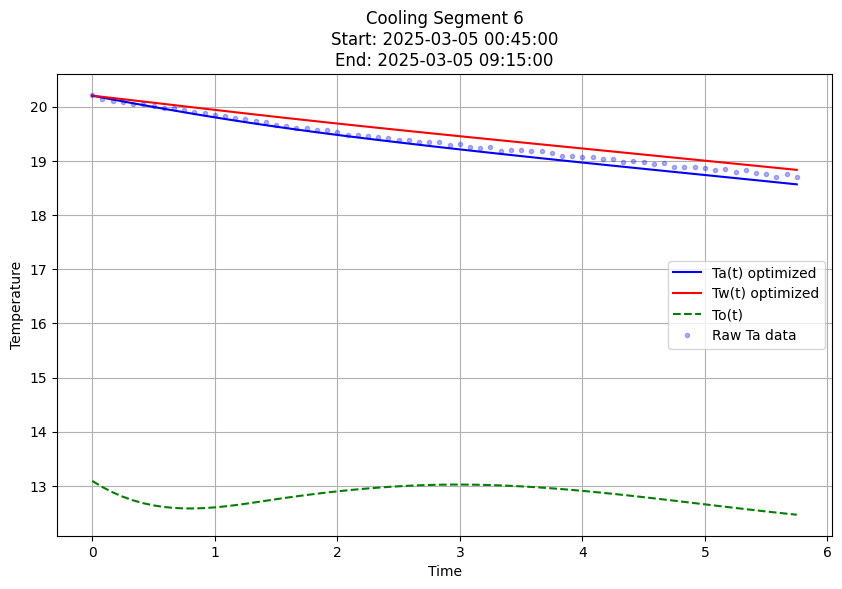

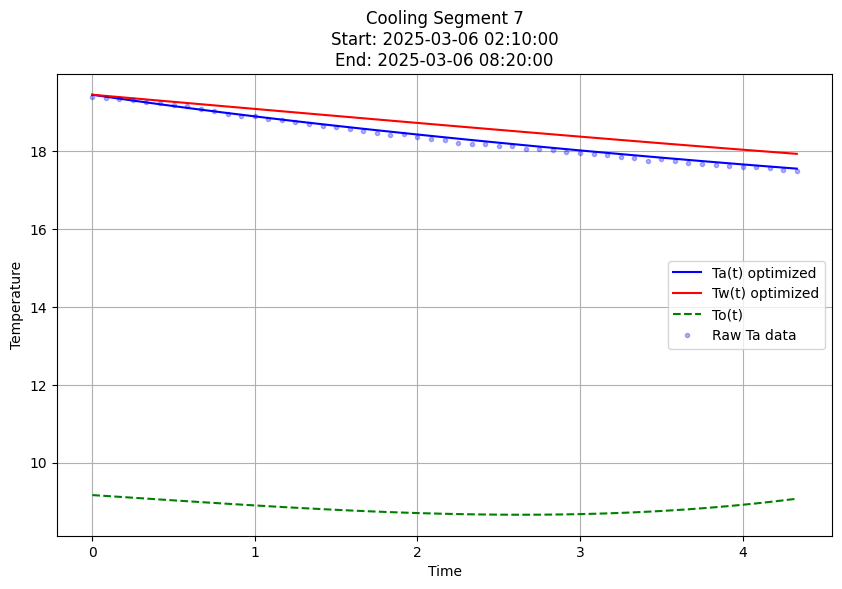

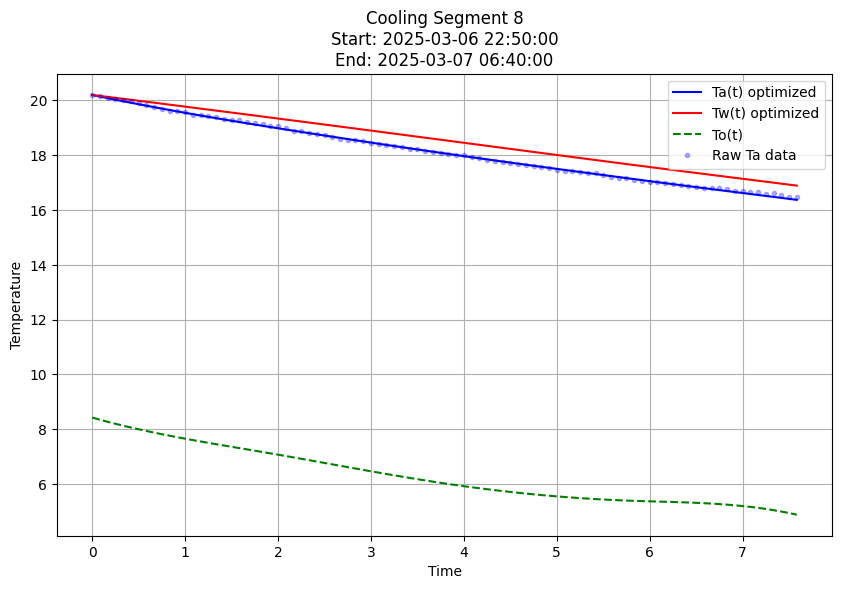

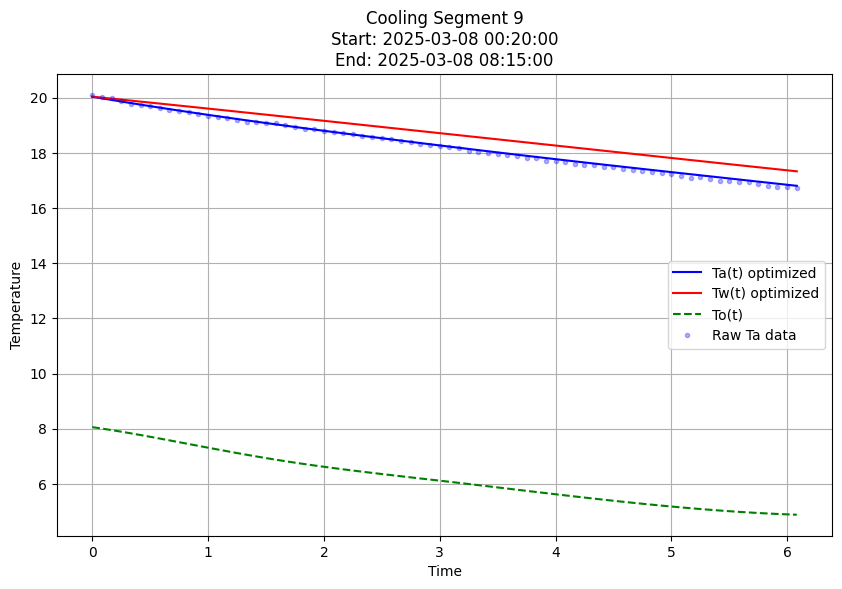

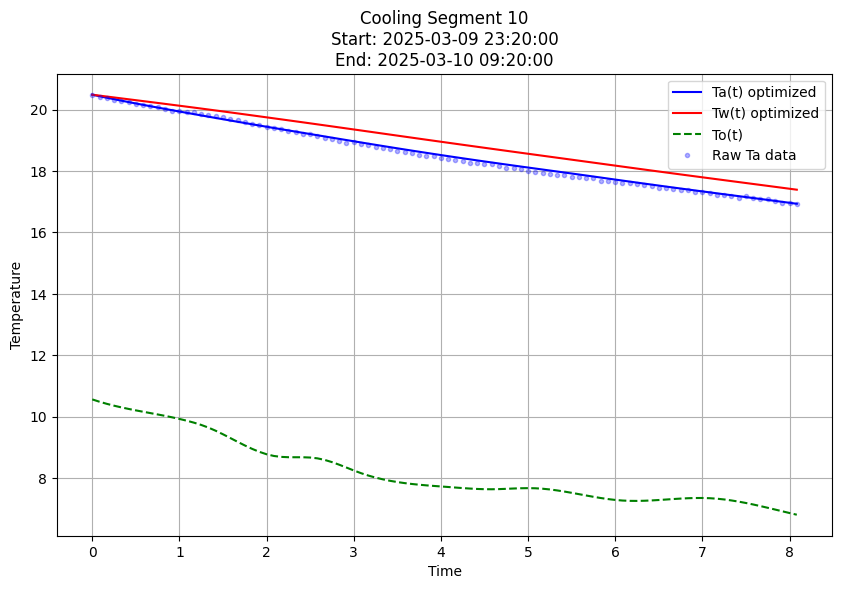

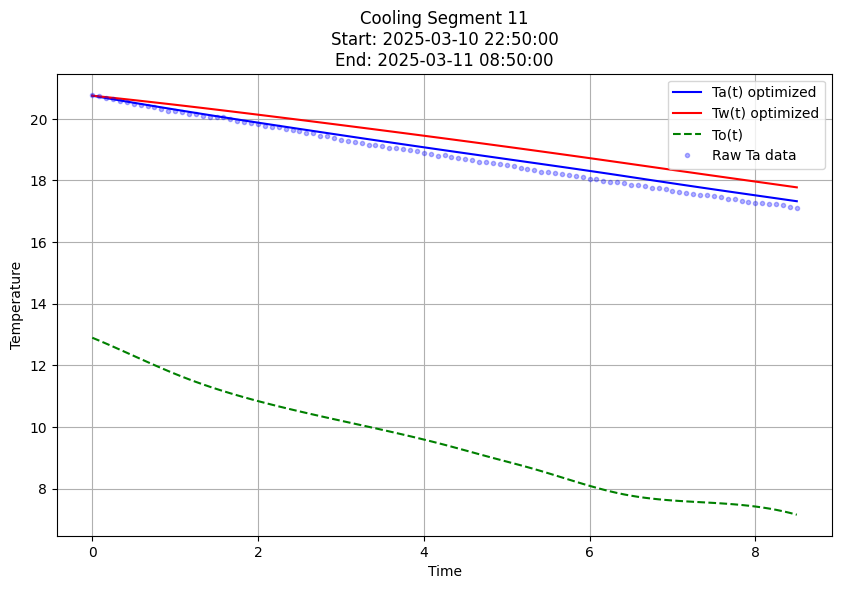

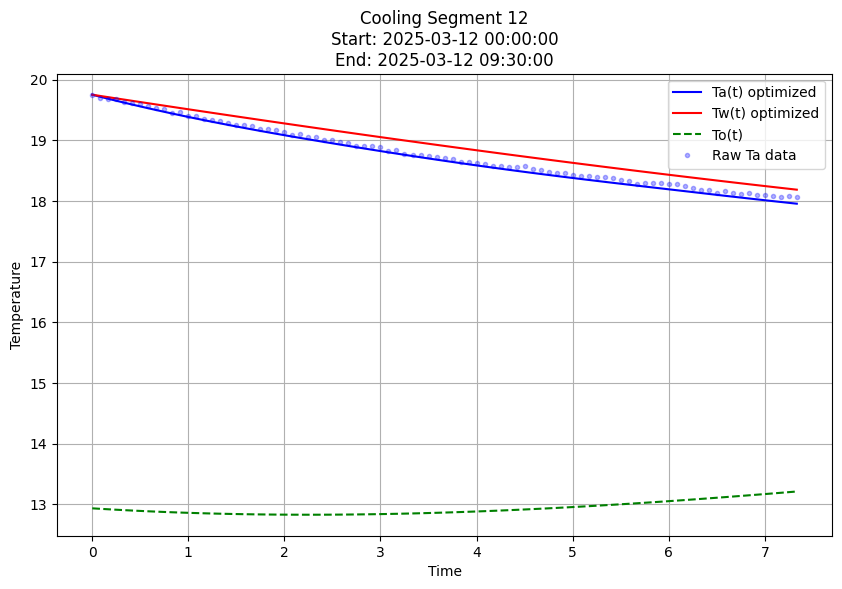

{'k1': 0.5,
 'k2': 0.06,
 'k3': 0.03560531538893532,
 'k4': 0.0,
 'R-squared': 0.9847464524831763}

In [50]:
fixed_params = {'k1': 0.5, 'k2': 0.06, 'k4': 0.0}
segments, title = segments_new[:9] + segments_new[10:], "New Door"
result = optimize_cooling_system(segments, title, fixed_params=fixed_params, plot_results=True)
result

Precomputing data for segments...
Starting optimization with multiple initial points...
Calculating confidence intervals...

---Old Door---

Parameters:
k1 = 0.500000 (fixed)
k2 = 0.060000 (fixed)
k3 = 0.038337 ± 69.515185
k4 = 0.000000 (fixed)

Goodness of fit:
R-squared = 0.9729

Generating plots...


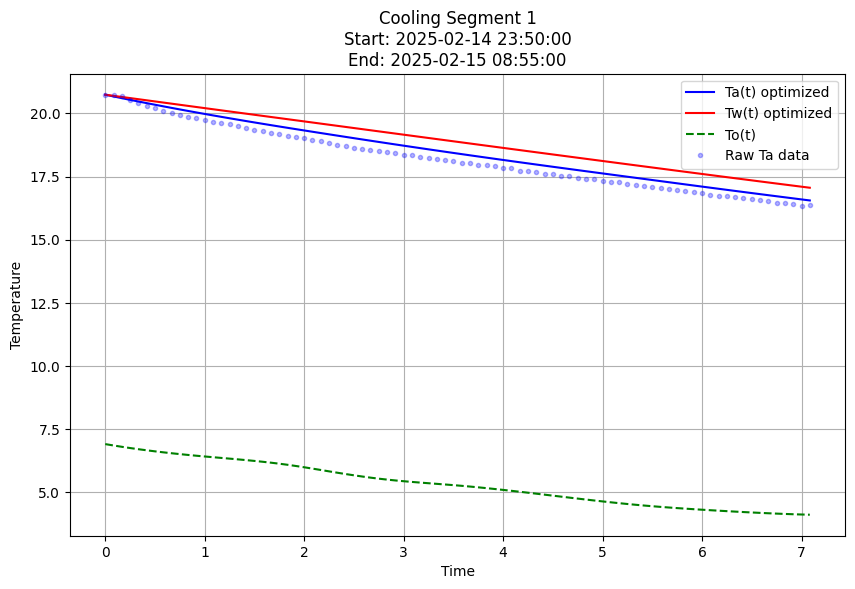

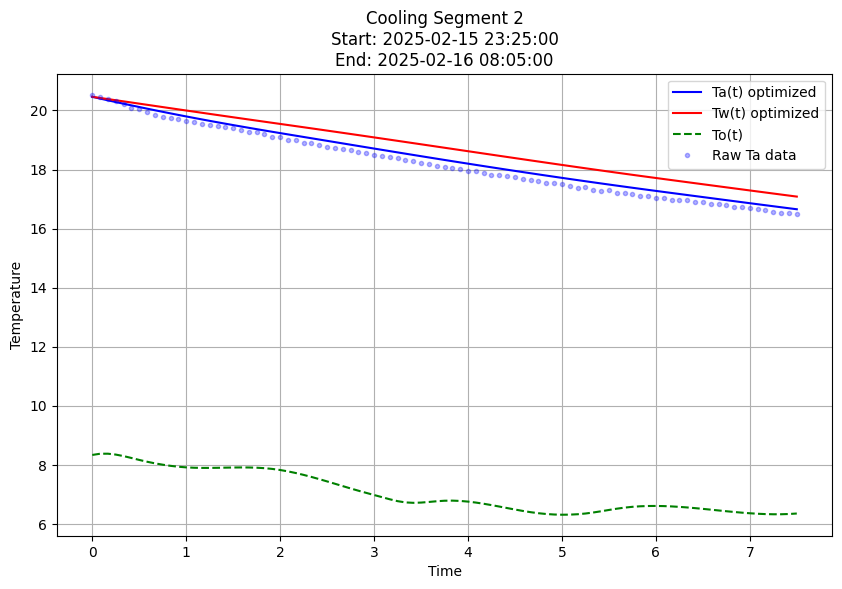

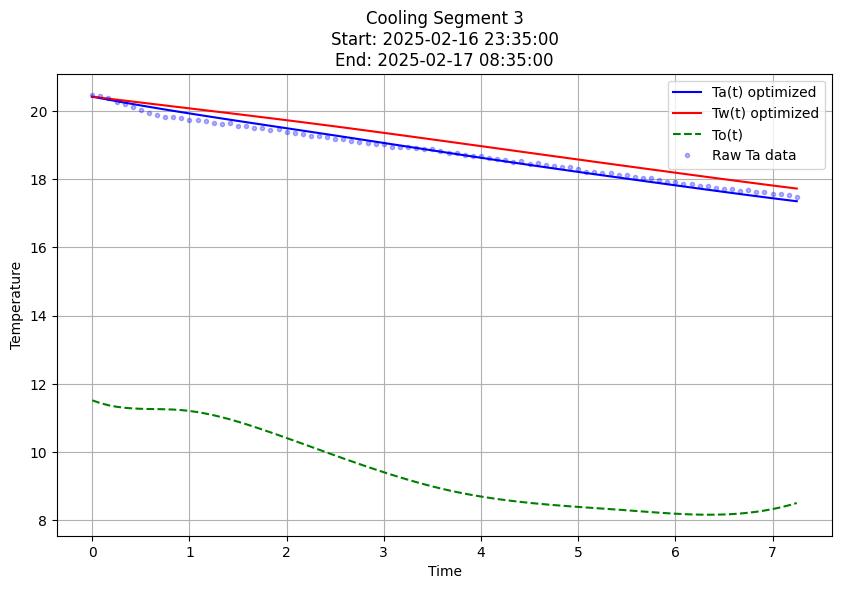

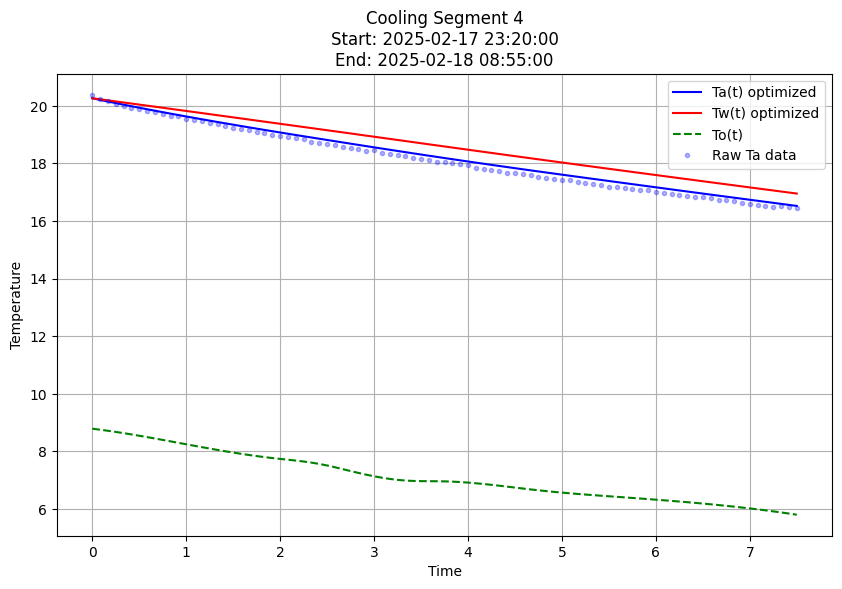

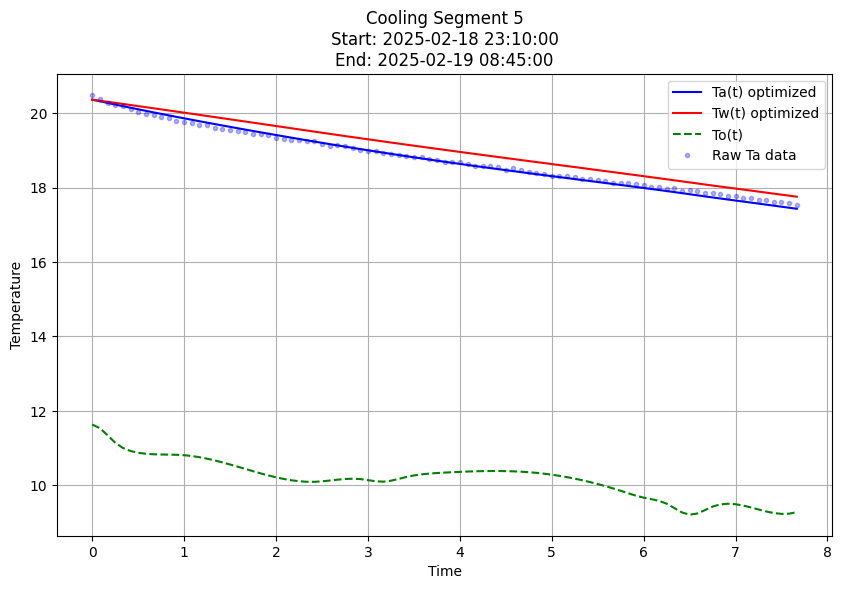

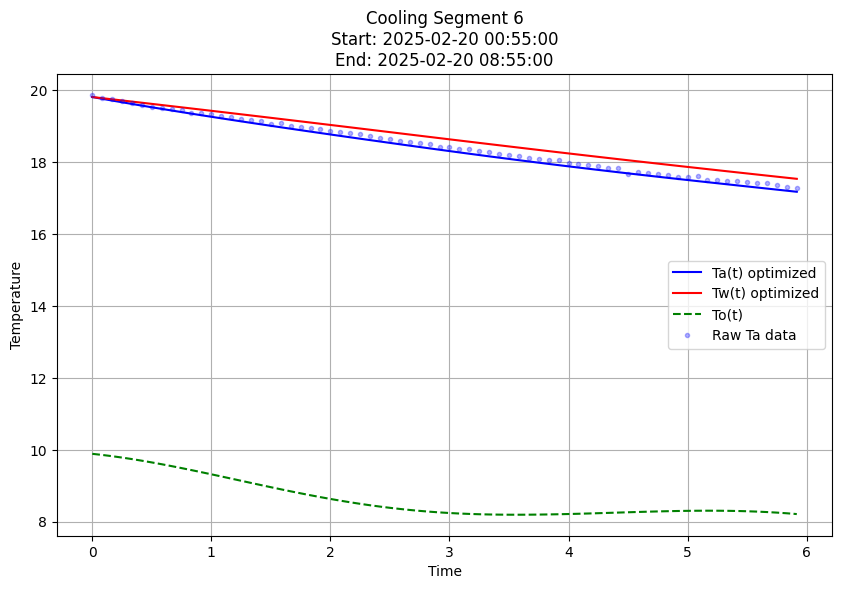

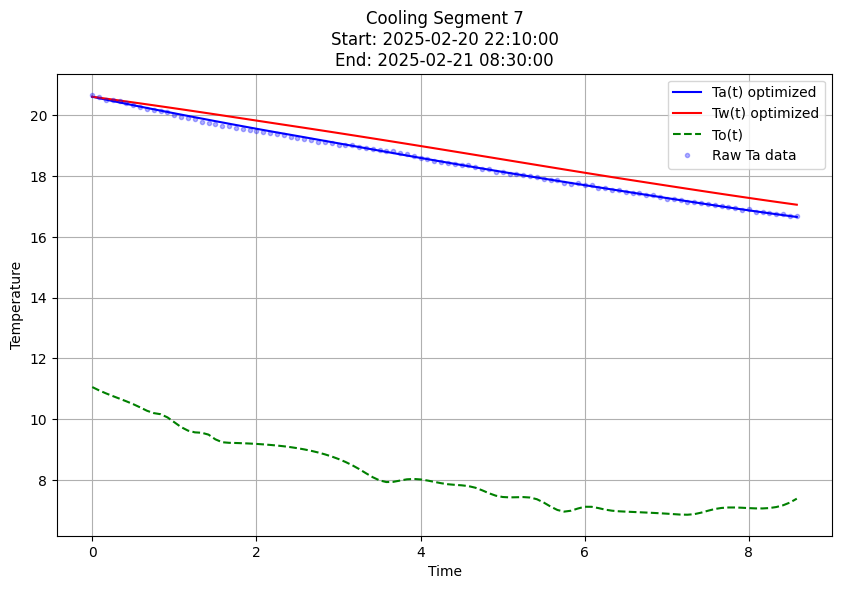

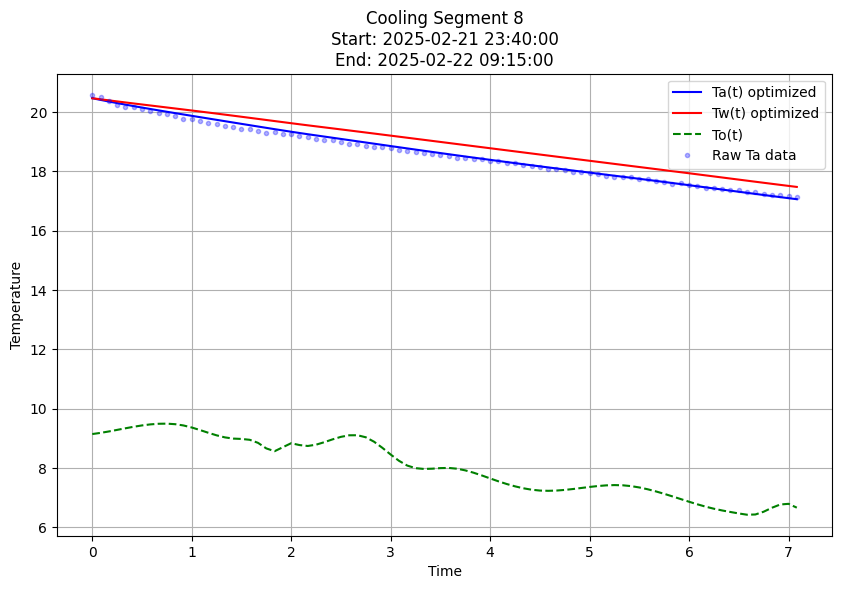

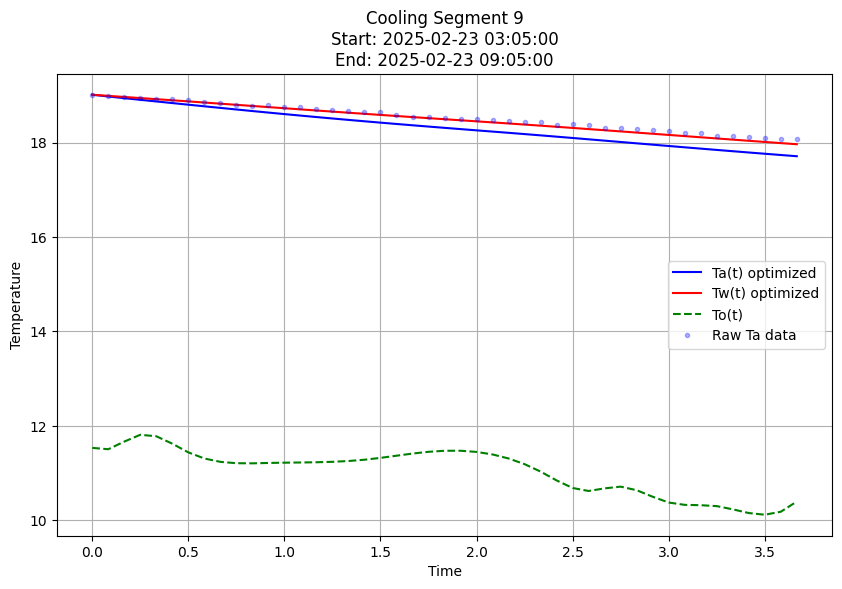

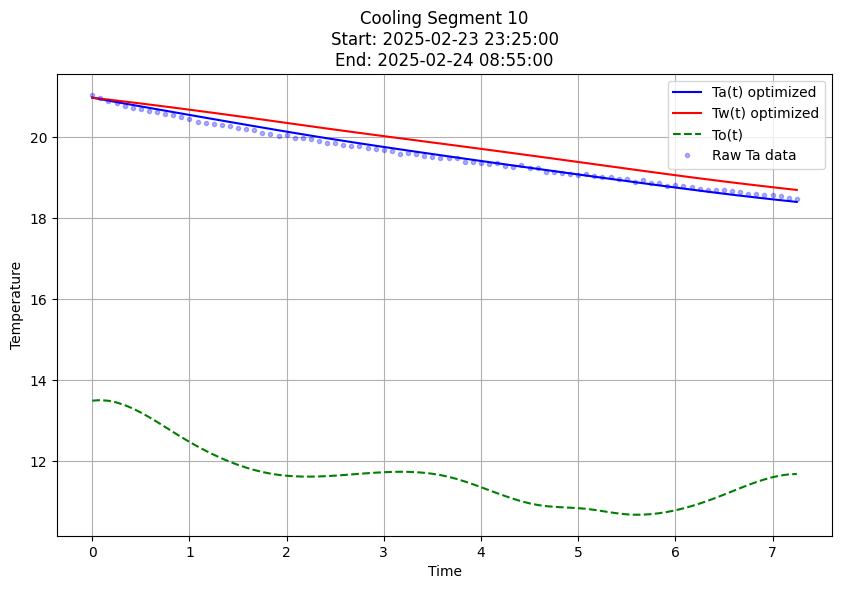

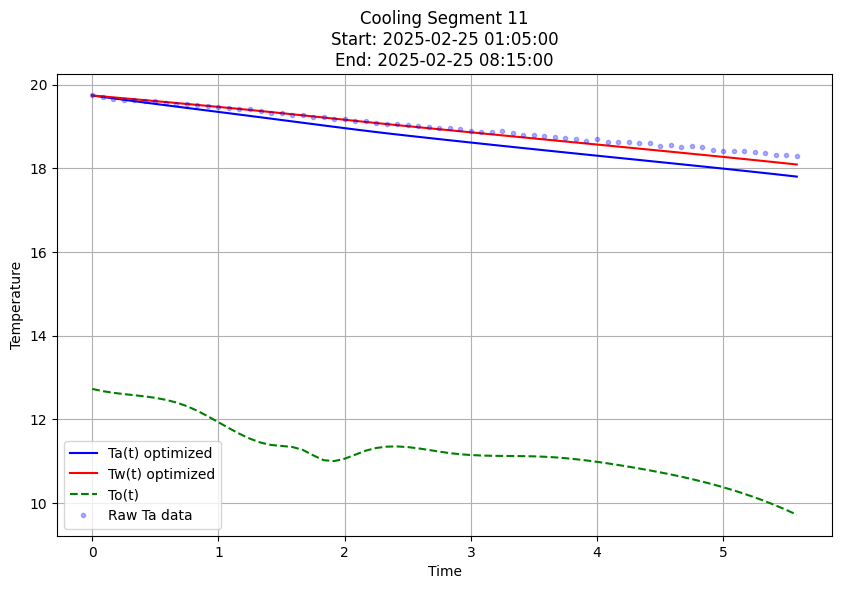

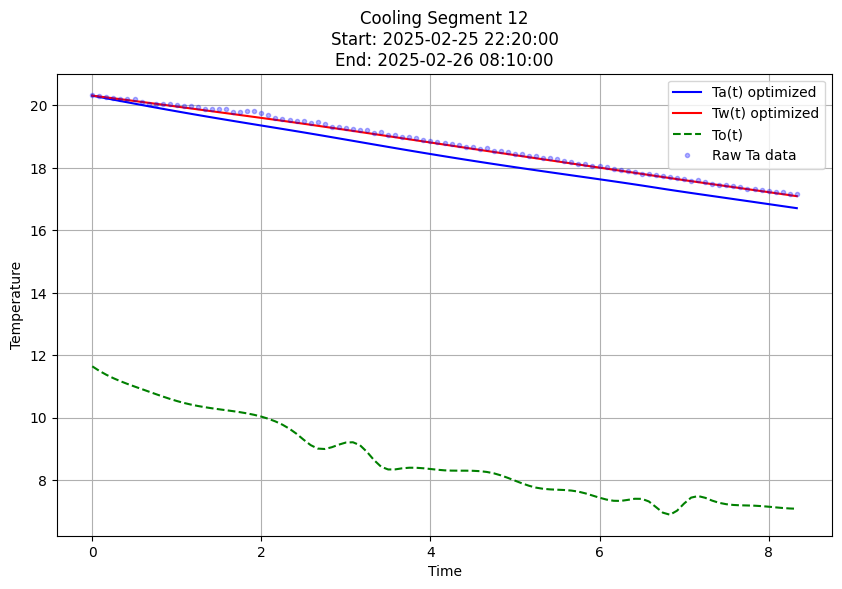

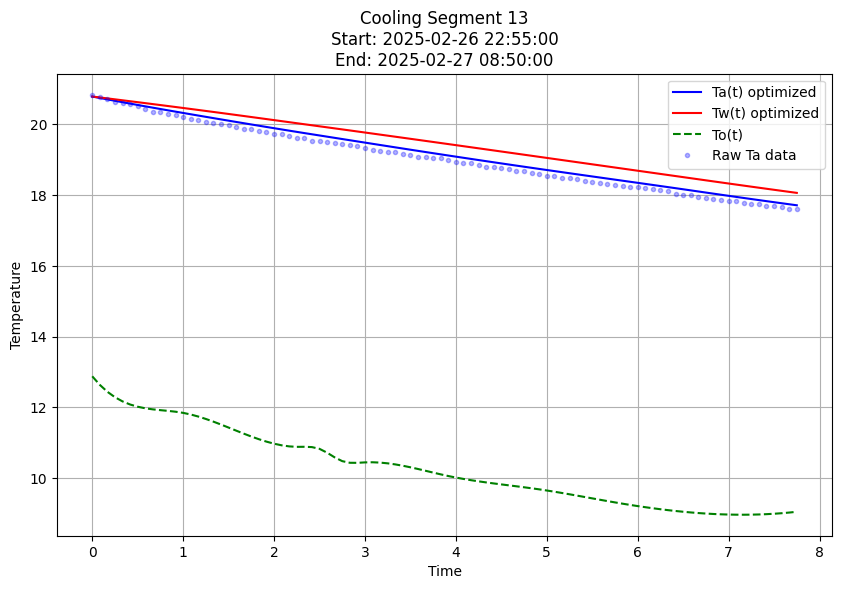

{'k1': 0.5,
 'k2': 0.06,
 'k3': 0.03833682416409773,
 'k4': 0.0,
 'R-squared': 0.9729205125418129}

In [40]:
fixed_params = {'k1': 0.5, 'k2': 0.06, 'k4': 0.0}
segments, title = segments_old, "Old Door"
result = optimize_cooling_system(segments, title, fixed_params=fixed_params, plot_results=True)
result

In [36]:
1./0.03560532250499573, 1./0.03833682308739075

(28.085688589386926, 26.08458185803369)